# Libraries and Importing

In [35]:
import pvlib
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta, time as dttime, date
import timeit
import random
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator
plt.rcParams["font.family"] = "Times New Roman"
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
# %matplotlib auto

In [2]:
class world:
    def __init__(self, starttime, endtime, wd):
        self.start = datetime.strptime(starttime, '%Y-%m-%d')
        self.current_time = datetime.strptime(starttime, '%Y-%m-%d')
        self.end = datetime.strptime(endtime, '%Y-%m-%d')
        self.wd = wd
    def pv(self, modules, strings, clearsky, stellies):
        self.pv_system = pv_setup(modules, strings)
        if clearsky:
            self.panel_output, self.system_output  = pv_output(self.start, self.end, self.pv_system, self.wd, 
                                                               True, stellies)
        else:
            self.panel_output, self.system_output  = pv_output(self.start, self.end, self.pv_system, self.wd, 
                                                               False, stellies)
    def update(self, minute):
        self.current_time = self.current_time + timedelta(minutes=minute)
    def update_day(self):
        self.current_time += timedelta(days=1)

# Energy Usage

#### Fix: Require at least one OPE, SE & PE for each month - for cost Calculations

In [3]:
def energy_profile(kwh):
    ## Ignoring 2015 Summer for now - Only difference is offpeak is from 8p-12p instead of 10p-12p

    ## pe: Peak Energy (kWh)    ## ope: Off Peak Energy (kWh)    ## se: Standard Energy (kWh)
    pe = pd.DataFrame(columns = ['Weekday', 'Sat', 'Sun'])
    ope = pd.DataFrame(columns = ['Weekday', 'Sat', 'Sun'])
    se = pd.DataFrame(columns = ['Weekday', 'Sat', 'Sun'])
    month = kwh.loc[kwh.index.month.isin([1,2,3,4,5,9,10,11,12])]
    month = month.reindex(kwh.index, fill_value = 0)
    week = month[month.index.dayofweek < 5]
    ope.iloc[:,0] = week.between_time('22:00', '06:00', True, False).resample('M').sum()
    se.iloc[:,0] = week.between_time('06:00', '07:00', True, False).resample('M').sum()
    pe.iloc[:,0] = week.between_time('07:00', '10:00', True, False).resample('M').sum()
    se.iloc[:,0] = se.iloc[:,0] + week.between_time('10:00', '18:00', True, False).resample('M').sum()
    pe.iloc[:,0] = pe.iloc[:,0] + week.between_time('18:00', '20:00', True, False).resample('M').sum()
    se.iloc[:,0] = se.iloc[:,0] + week.between_time('20:00', '22:00', True, False).resample('M').sum()
    week = month[month.index.dayofweek == 5]
    ope.iloc[:,1] = week.between_time('20:00', '07:00', True, False).resample('M').sum()
    se.iloc[:,1] = week.between_time('07:00', '12:00', True, False).resample('M').sum()
    ope.iloc[:,1] = ope.iloc[:,1] + week.between_time('12:00', '18:00', True, False).resample('M').sum()
    se.iloc[:,1] = se.iloc[:,1] + week.between_time('18:00', '20:00', True, False).resample('M').sum()
    week = month[month.index.dayofweek == 6]
    ope.iloc[:,2] = week.resample('M').sum()
    month = kwh.loc[kwh.index.month.isin([6,7,8])]
    month = month.reindex(kwh.index, fill_value = 0)
    week = month[month.index.dayofweek < 5]
    ope.iloc[:,0] = ope.iloc[:,0] + week.between_time('22:00', '06:00', True, False).resample('M').sum()
    pe.iloc[:,0] = pe.iloc[:,0] + week.between_time('06:00', '09:00', True, False).resample('M').sum()
    se.iloc[:,0] = se.iloc[:,0] + week.between_time('9:00', '17:00', True, False).resample('M').sum()
    pe.iloc[:,0] = pe.iloc[:,0] + week.between_time('17:00', '19:00', True, False).resample('M').sum()
    se.iloc[:,0] = se.iloc[:,0] + week.between_time('19:00', '22:00', True, False).resample('M').sum()
    week = month[month.index.dayofweek == 5]
    ope.iloc[:,1] = ope.iloc[:,1] + week.between_time('20:00', '07:00', True, False).resample('M').sum()
    se.iloc[:,1] = se.iloc[:,1] + week.between_time('07:00', '12:00', True, False).resample('M').sum()
    ope.iloc[:,1] = ope.iloc[:,1] + week.between_time('12:00', '18:00', True, False).resample('M').sum()
    se.iloc[:,1] = se.iloc[:,1] + week.between_time('18:00', '20:00', True, False).resample('M').sum()
    week = month[month.index.dayofweek == 6]
    ope.iloc[:,2] = ope.iloc[:, 2] + week.resample('M').sum()    
    
    ope = ope.set_index(ope.index.strftime('%Y-%m'))
    pe = pe.set_index(pe.index.strftime('%Y-%m'))
    se = se.set_index(se.index.strftime('%Y-%m'))
    energy = pd.DataFrame()
    energy['ope'] = ope.sum(axis=1)
    energy['se'] = se.sum(axis=1)
    energy['pe'] = pe.sum(axis=1)

    return energy, pe, se, ope

# Costs

In [4]:
def cost_profile(kwh, pe, se, ope, pk_ev, pk_employer):
    pec = pe.copy()
    opec = ope.copy()
    sec = se.copy()
    ## Location and value of max kVA respectively
    idkva = (kwh.kVA.groupby(pd.Grouper(freq='1m')).idxmax())
#     maxkva = kwh.kVA.reindex(idkva)
    maxkva = (pk_ev-pk_employer)/.001
    dates = pd.period_range(kwh.index[0], kwh.index[-1], freq='M')
    dates = dates.strftime('%Y-%m')
    dates_size = int(dates.size)
#     dates_size = idkva.shape[0]
    for i in range(dates_size): 
        if idkva[i].month >= 9:
            if idkva[i].year == 2015:
                pec.iloc[i] = pe.iloc[i]*ts20156[3]
                opec.iloc[i] = ope.iloc[i]*ts20156[5]
                sec.iloc[i] = se.iloc[i]*ts20156[4]
            elif idkva[i].year == 2016:
                pec.iloc[i] = pe.iloc[i]*ts20167[3]
                opec.iloc[i] = ope.iloc[i]*ts20167[5]
                sec[i] = se.iloc[i]*ts20167[4]
            elif idkva[i].year == 2017:
                pec.iloc[i] = pe.iloc[i]*ts20178[3]
                opec.iloc[i] = ope.iloc[i]*ts20178[5]
                sec.iloc[i] = se.iloc[i]*ts20178[4]
            elif idkva[i].year == 2018:
                pec.iloc[i] = pe.iloc[i]*ts20189[3]
                opec.iloc[i] = ope.iloc[i]*ts20189[5]
                sec.iloc[i] = se.iloc[i]*ts20189[4]
            elif idkva[i].year == 2019:
                pec.iloc[i] = pe.iloc[i]*ts20190[3]
                opec.iloc[i] = ope.iloc[i]*ts20190[5]
                sec.iloc[i] = se.iloc[i]*ts20190[4]
        elif idkva[i].month <= 5:
            if idkva[i].year == 2016:
                pec.iloc[i] = pe.iloc[i]*ts20156[3]
                opec.iloc[i] = ope.iloc[i]*ts20156[5]
                sec.iloc[i] = se.iloc[i]*ts20156[4]
            elif idkva[i].year == 2017:
                pec.iloc[i] = pe.iloc[i]*ts20167[3]
                opec.iloc[i] = ope.iloc[i]*ts20167[5]
                sec.iloc[i] = se.iloc[i]*ts20167[4]
            elif idkva[i].year == 2018:
                pec.iloc[i] = pe.iloc[i]*ts20178[3]
                opec.iloc[i] = ope.iloc[i]*ts20178[5]
                sec.iloc[i] = se.iloc[i]*ts20178[4]
            elif idkva[i].year == 2019:
                pec.iloc[i] = pe.iloc[i]*ts20189[3]
                opec.iloc[i] = ope.iloc[i]*ts20189[5]
                sec.iloc[i] = se.iloc[i]*ts20189[4]
        elif idkva[i].month == 6:
            if idkva[i].year == 2016:
                pec.iloc[i] = pe.iloc[i]*tw20156[3]
                opec.iloc[i] = ope.iloc[i]*tw20156[5]
                sec.iloc[i] = se.iloc[i]*tw20156[4]
            elif idkva[i].year == 2017:
                pec.iloc[i] = pe.iloc[i]*tw20167[3]
                opec.iloc[i] = ope.iloc[i]*tw20167[5]
                sec.iloc[i] = se.iloc[i]*tw20167[4]
            elif idkva[i].year == 2018:
                pec.iloc[i] = pe.iloc[i]*tw20178[3]
                opec.iloc[i] = ope.iloc[i]*tw20178[5]
                sec.iloc[i] = se.iloc[i]*tw20178[4]
            elif idkva[i].year == 2019:
                pec.iloc[i] = pe.iloc[i]*tw20189[3]
                opec.iloc[i] = ope.iloc[i]*tw20189[5]
                sec.iloc[i] = se.iloc[i]*tw20189[4]
        else:
            if idkva[i].year == 2015:
                pec.iloc[i] = pe.iloc[i]*tw20156[3]
                opec.iloc[i] = ope.iloc[i]*tw20156[5]
                sec.iloc[i] = se.iloc[i]*tw20156[4]
            elif idkva[i].year == 2016:
                pec.iloc[i] = pe.iloc[i]*tw20167[3]
                opec.iloc[i] = ope.iloc[i]*tw20167[5]
                sec.iloc[i] = se.iloc[i]*tw20167[4]
            elif idkva[i].year == 2017:
                pec.iloc[i] = pe.iloc[i]*tw20178[3]
                opec.iloc[i] = ope.iloc[i]*tw20178[5]
                sec.iloc[i] = se.iloc[i]*tw20178[4]
            elif idkva[i].year == 2018:
                pec.iloc[i] = pe.iloc[i]*tw20189[3]
                opec.iloc[i] = ope.iloc[i]*tw20189[5]
                sec.iloc[i] = se.iloc[i]*tw20189[4]
            elif idkva[i].year == 2019:
                pec.iloc[i] = pe.iloc[i]*tw20190[3]
                opec.iloc[i] = ope.iloc[i]*tw20190[5]
                sec.iloc[i] = se.iloc[i]*tw20190[4]
    costs = pd.DataFrame(0, np.arange(dates_size), columns = ['Fixed', 'Demand', 'Access', 'Reactive'])
    ### Demand, Fixed and Access Charge
    access_charge = 138
    for i in range(dates_size):
        if(idkva[i].month <= 6):
            if(idkva[i].year == 2016):
                costs.iloc[i, 0] = tw20156[0]
                costs.iloc[i, 1] = maxkva[i]*tw20156[1]
                costs.iloc[i, 2] = access_charge*tw20156[2]
            elif(idkva[i].year == 2017):
                costs.iloc[i, 0] = tw20167[0]
                costs.iloc[i, 1] = maxkva[i]*tw20167[1]
                costs.iloc[i, 2] = access_charge*tw20167[2]
            elif(idkva[i].year == 2018):
                costs.iloc[i, 0] = tw20178[0]
                costs.iloc[i, 1] = maxkva[i]*tw20178[1]
                costs.iloc[i, 2] = access_charge*tw20178[2]
            elif(idkva[i].year == 2019):
                costs.iloc[i, 0] = tw20189[0]
                costs.iloc[i, 1] = maxkva[i]*tw20189[1]
                costs.iloc[i, 2] = access_charge*tw20189[2]
        else:
            if(idkva[i].year == 2015):
                costs.iloc[i, 0] = tw20156[0]
                costs.iloc[i, 1] = maxkva[i]*tw20156[1]
                costs.iloc[i, 2] = access_charge*tw20156[2]
            elif(idkva[i].year == 2016):
                costs.iloc[i, 0] = tw20167[0]
                costs.iloc[i, 1] = maxkva[i]*tw20167[1]
                costs.iloc[i, 2] = access_charge*tw20167[2]
            elif(idkva[i].year == 2017):
                costs.iloc[i, 0] = tw20178[0]
                costs.iloc[i, 1] = maxkva[i]*tw20178[1]
                costs.iloc[i, 2] = access_charge*tw20178[2]
            elif(idkva[i].year == 2018):
                costs.iloc[i, 0] = tw20189[0]
                costs.iloc[i, 1] = maxkva[i]*tw20189[1]
                costs.iloc[i, 2] = access_charge*tw20189[2]
            elif(idkva[i].year == 2019):
                costs.iloc[i, 0] = tw20190[0]
                costs.iloc[i, 1] = maxkva[i]*tw20190[1]
                costs.iloc[i, 2] = access_charge*tw20190[2]
    costs['Date/Time'] = dates
    costs = costs.set_index('Date/Time')
    # costs['Weekday'] = (pec['Weekday'] + opec['Weekday'] + sec['Weekday'])
    # costs['Weekend'] = (pec['Sat'] + opec['Sat'] + sec['Sat'] + pec['Sun'] + opec['Sun'] + sec['Sun'])
    costs['pec'] = (pec.sum(axis=1).values)
    costs['opec'] = (opec.sum(axis=1).values)
    costs['sec'] = (sec.sum(axis=1).values)
    return costs

# Financial Information

##### From July 1st New fees go into effect

##### Winter 2015-2019: June-August
Mon-Fri: 12a-6a Off, 6a-9a Pea, 9a-5p Sta, 5p-7p Pea, 7p-10p Sta, 10p-6a off
Sat: 7a-12p Sta, 12p-6p Off, 6p-8p Sta, 8p-12a Off
Sun: Off Peak
##### Summer 2017-2019: September-May
Mon-Fri: 12a-6a Off, 6a-7a Sta, 7a-10a Pea, 10a-6p Sta, 6p-8p Pea, 8p-10p Sta, 10p-12a off
Sat: 7a-12p Sta, 12p-6p Off, 6p-8p Sta, 8p-12a Off
Sun: Off Peak
##### Summer 2015: September-May
Mon-Fri: 12a-6a Off, 6a-7a Sta, 7a-10a Pea, 10a-6p Sta, 6p-8p Pea, 8p-12a off
Sat: 7a-12p Sta, 12p-6p Off, 6p-8p Sta, 8p-12a Off
Sun: Off Peak

In [5]:
### Tariff Structure
## [fixed/month(R), demand(R/kVA), access(R/kVA), Peak(R/kWh), standard(R/kWh), off(R/kWh), reactive(R/kVArh)]

##TOU1
# tw20190 = [3502.91, 47.49, 47.49, 4.8718, 1.4622, 0.8591, 0.2032]
# ts20190 = [3502.91, 47.49, 47.49, 1.5536, 1.0237, 0.7677, 0.0]
# tw20189 = [3098, 42, 42, 4.3087, 1.2932, 0.7598, 0.1791]
# ts20189 = [3098, 42, 42, 1.3740, 0.9054, 0.6790, 0.0]
# tw20189 = [3059.45, 40.09, 39.52, 4.2357, 1.2713, 0.7470, 0.1767]
# ts20189 = [3059.45, 40.09, 39.52, 1.3508, 0.89, 0.6675, 0.0]
# tw20178 = [2846, 38, 38, 3.9586, 1.1881, 0.6981, 0.1651]
# ts20178 = [2846, 38, 38, 1.2624, 0.8318, 0.6238, 0.0]
tw20167 = [2784, 37, 37, 3.8725, 1.1623, 0.6829, 0.1615]
ts20167 = [2784, 37, 37, 1.2349, 0.8137, 0.6102, 0.0]
tw20156 = [2586, 34, 34, 3.5975, 1.0798, 0.6344, 0.1521]
ts20156 = [2586, 34, 34, 1.1472, 0.7559, 0.5669, 0.0]

##TOU2
tw20190 = [6453.73, 46.97, 44.68, 4.8433, 1.3758, 0.8087, 0.2078]
ts20190 = [6453.73, 46.97, 44.68, 1.4662, 0.9591, 0.7188, 0.0]
tw20189 = [5633, 41, 39, 4.2274, 1.2008, 0.7059, 0.1814]
ts20189 = [5633, 41, 39, 1.2797, 0.8371, 0.6274, 0.0]
# tw20189 = [5512.6, 39.04, 36.4, 4.1178, 1.1697, 0.6876, 0.1767]
# ts20189 = [5512.6, 39.04, 36.4, 1.2466, 0.8154, 0.6112, 0.0]
tw20178 = [5128, 37, 35, 3.8484, 1.0932, 0.6426, 0.1651]
ts20178 = [5128, 37, 35, 1.165, 0.7621, .5712, 0.0]

# tariff = pd.DataFrame()
### Home Owner Perspective ###
#[fixed/month (R), Rate<50kWh(R/kWh), Rate = 51-300kWh (R/kWh), rate = 301-600kWh (R/kWh), rate>600kWh (R/kWh)]
homet_20190 = [174.89, 1.0339, 1.3262, 1.8709, 2.2032]
homet_20189 = [154.67, 0.9144, 1.1729, 1.6546, 1.9485]



### 2019 ###
coastal_95 = [1342.00, 1349.00, 1423.00, 1549.00, 1603.00, 1612.00, 1517.00, 1528.00, 1539.00, 1557.00, 1544.00, 1566.00]
#Update These guys
### 2019 Jan - Sept & 2018 Oct, Nov, Dec Petrol Prices (c/litre) ###
gaut_95 = [1401.00, 1408.00, 1482.00, 1613.00, 1667.00, 1676.00, 1581.00, 1592.00, 1603.00, 1708.00, 1708.00, 1524.00]
gaut_93 = [1379.00, 1386.00, 1460.00, 1594.00, 1648.00, 1657.00, 1561.00, 1572.00, 1583.00, 1685.00, 1685.00, 1501.00]
fuel_price = coastal_95

# Weather Data Import

In [9]:
data = pd.read_csv('../data/weather/sb_tmin_raw1.csv', header=0)
data1 = pd.read_csv('../data/weather/sb_tmin_raw2.csv', header=0)
data2 = pd.read_csv('../data/weather/sb_tmin_raw3.csv', header=0)
data3 = pd.read_csv('../data/weather/sb_tmin_raw4.csv', header=0)
wd = data.append(data1)
wd = wd.append(data2)
wd = wd.append(data3)
wd = wd[['TimeStamp', 'TrackerWM_Avg', 'ShadowWM_Avg', 'SunWM_Avg', 'AirTC_Avg', 'WS_ms_S_WVT']]
wd.columns = ['TimeStamp', 'dni', 'dhi', 'ghi', 'temp', 'wind']
wd.loc[:,'TimeStamp'] = pd.to_datetime(wd.loc[:,'TimeStamp'])
wd = wd.set_index('TimeStamp')
# wd=0

# Electricity Data Import

In [6]:
eskom = pd.read_excel('../data/energy/2012-2017_eskom_grid_usage.xlsx', 'Bowen2017', header=None)
eskom['Date/Time'] = pd.date_range(start = '1/1/2017', end='12/31/2017 23:00', freq='H')
eskom.set_index('Date/Time', inplace=True)

In [7]:
def outlier_and_fill(outlier_index, md, i):
        outlier_index[i] = (md[md>3000].dropna(how='all'))
        md.loc[outlier_index[i].index] = np.nan
        
        na = md[md.isnull().any(axis=1)]
        months = na.groupby(na.index.month).sum().index
        if na.shape[0] == 0:
            print('move on')
        else:
            for x in months:
                na_month = na[na.index.month == x].index
                month_now = na_month[0].date().replace(day=1)
                month_index = md[month_now:month_now+timedelta(days=30)].index
                fill_mean = md[month_index[0]:month_index[-1]].groupby(month_index.time).mean()
                for j in range(fill_mean.shape[0]):
                    for k in range(4):
                        md.loc[na_month[na_month.time == fill_mean.index[j]],fill_mean.columns[k]] = fill_mean.iloc[j,k]

In [9]:
su = pd.read_csv('../data/energy/su_2018.csv', header=0)
su_2019 = pd.read_csv('../data/energy/su_2019.csv', header=0)
col = ['ImpkWh', 'Ptot', 'Stot', 'PFtot']
for i in col:
    su.loc[:1702, i] = su_2019.loc[:1702, i]
su_2019 = 0
su = su.set_index('Meter Name')
meters = su.index.unique()
md={}
outlier_index={}
su_data = pd.DataFrame()
for i in meters:
    md[i]=su.loc[i,['Timestamp','ImpkWh',"Ptot", 'Stot', 'PFtot']]
    md[i]['Timestamp'] = pd.to_datetime(md[i].loc[:,'Timestamp']).values
    md[i].set_index('Timestamp', inplace=True)
    outlier_and_fill(outlier_index, md[i], i)
    if i == meters[0]:
        su_data[0] = md[i].loc[:,'Ptot'].values
        su_data['kWh'] = md[i].loc[:,'ImpkWh'].values
        su_data['kVA'] = md[i].loc[:,'Stot'].values
        su_data['PF'] = md[i].loc[:,'PFtot'].values
    else:
        su_data[0] += md[i].loc[:,'Ptot'].values
        su_data['kWh'] += md[i].loc[:,'ImpkWh'].values
        su_data['kVA'] += md[i].loc[:,'Stot'].values
        su_data['PF'] += md[i].loc[:,'PFtot'].values

su_data.loc[:,'PF'] = su_data.loc[:,'PF']/(meters.shape[0]) 
su_data['Date/Time'] = md[meters[0]].index
su_data.set_index('Date/Time', inplace=True)

startdate = su_data.index[0].date().strftime('%Y-%m-%d')
enddate = (su_data.index[-1].date()+timedelta(days=1)).strftime('%Y-%m-%d')
sd = pd.date_range(startdate, enddate, freq='30min')
# sd=pd.DatetimeIndex(start=startdate, end=enddate, freq='30min')
su_data = su_data.reindex(sd)
su_data = su_data.shift(-1).dropna()


## PV Power

In [11]:
def pv_setup(modules, strings):
    # https://www.solarpanelenergy.co.za/docs/325W%20330W%20335W%20340W%20Canadian%20solar%20panelDatasheetCS6KP.pdf
    module = pvlib.pvsystem.retrieve_sam(name='CECMod')['Canadian_Solar_Inc__CS6U_330P']
    module['EgRef'] = 1.121
    module['dEgdT'] = -0.0002677
    inverter = pvlib.pvsystem.retrieve_sam(name='CECInverter')['SMA_America__SB4000TL_US_22__240V_']
    
    # Single Bay Parking (2.5 x 5 m ---> 5 Panels)
    # system = pvlib.pvsystem.PVSystem(module_parameters=module, modules_per_string=5, strings_per_inverter=1)
    system = pvlib.pvsystem.PVSystem(module_parameters=module, modules_per_string=modules, strings_per_inverter=strings,
                                     inverter_parameters=inverter)    
    
    # Two bay parking (5 x 6 m ---> 15 Panels)
    # system = pvlib.pvsystem.PVSystem(module_parameters=module, modules_per_string=15, strings_per_inverter=1)
    return system
def pv_output(startdate, enddate, system, wd, clearsky, stellies):
#     period = pd.DatetimeIndex(start=startdate, end=enddate, freq='1min')
    period = pd.date_range(startdate, enddate, freq='1min')
    wd_period = wd.reindex(period)
    wd_period = wd_period.dropna()
    period = wd_period.index
    if stellies:
        pv_site = pvlib.location.Location(-33.946, 18.856, 'Africa/Johannesburg', 99, 'Stellenbosch')
        period = period.tz_localize('Africa/Johannesburg')
        wd_period = wd_period.tz_localize('Africa/Johannesburg')
    else:
        pv_site = pvlib.location.Location(-43.5353185, 172.6375334, 'NZ', 13, 'Christchurch')
        period = pd.DatetimeIndex(start=stellenbosch.start, end=stellenbosch.end, freq='1min', tz='NZ')
        wd_period = wd_period.tz_localize('NZ')

    solarpos = pvlib.solarposition.get_solarposition(period, pv_site.latitude, pv_site.longitude)
    dni_extra = pvlib.irradiance.get_extra_radiation(period)
    surface_tilt = 15
#     surface_azimuth = 30
#     abs(pv_site.latitude)
#     surface_tilt = 29
    surface_azimuth = 0
    airmass = pvlib.atmosphere.get_relative_airmass(solarpos.apparent_zenith)
    if clearsky:
        pressure = pvlib.atmosphere.alt2pres(pv_site.altitude)
        ab_am = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
        linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(period, pv_site.latitude, pv_site.longitude)
        cs = pvlib.clearsky.ineichen(solarpos.apparent_zenith, ab_am, linke_turbidity, pv_site.altitude, dni_extra)
        cs_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt, surface_azimuth, solarpos.apparent_zenith,
                                                        solarpos.azimuth, cs.dni, cs.ghi, cs.dhi, 
                                                        dni_extra=dni_extra, airmass=airmass, model='haydavies')
        irrad = cs_irrad
    else:
        wd_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt, surface_azimuth, solarpos.apparent_zenith, 
                                                         solarpos.azimuth, wd_period.dni, wd_period.ghi, wd_period.dhi, 
                                                         dni_extra=dni_extra, airmass=airmass, model='haydavies')
        irrad = wd_irrad
        
    irrad_sample = pd.DataFrame()
    irrad_sample['global'] = irrad.poa_global
    if stellies:
#         irrad_sample.index = irrad_sample.index.tz_localize(None)
#         irrad.index = irrad.index.tz_localize(None)
        irrad_sample = pd.concat([irrad_sample, pvlib.pvsystem.sapm_celltemp(irrad.poa_global, wd_period.wind, 
                                                                             wd_period.temp)], sort='False', axis = 1)

    else:
        irrad_sample = pd.concat([irrad_sample, pvlib.pvsystem.sapm_celltemp(irrad.poa_global, 0, 
                                                                             15)], sort='False', axis = 1)

    
    irrad_sample.index = irrad_sample.index.tz_localize(None)
    irrad.index = irrad.index.tz_localize(None)    
    irrad_sample.columns = ['global', 'temp_cell']

    I_L, Io, R_s, R_sh, nNsVth = system.calcparams_cec(irrad.poa_global, irrad_sample.temp_cell)
  
#     I_L, Io, R_s, R_sh, nNsVth = system.calcparams_desoto(irrad.poa_global, irrad_sample.temp_cell)
    sd_out = system.singlediode(I_L, Io, R_s, R_sh, nNsVth)
    scaled_values = system.scale_voltage_current_power(sd_out)
    # Inverter efficiency
    scaled_values.loc[:,'p_mp'] = system.snlinverter(scaled_values.v_mp, scaled_values.p_mp)

    return sd_out, scaled_values


# Electric Vehicles Setup

In [12]:
#### Capacity 85 % of stated claim ####
### Range is 85 % of stated range (150 miles) ###
car = {}
capacity_leaf = 40
range_leaf = ((1.60934/1)*150)
# car['Leaf'] = {'max_capacity':capacity_leaf, 'max_range':range_leaf, 'max_power':6.67, 'charge_rate':0, 
#                'current_capacity':capacity_leaf, 'current_range':range_leaf, 'current_efficiency':0, 'charging':False}

car['Leaf'] = {'charge_rate':0, 'charging':False,'current_capacity':capacity_leaf,'current_efficiency':0,
               'current_range':range_leaf, 'max_capacity':capacity_leaf,'max_power':6.67,'max_range':range_leaf}
car['Leaf']['current_efficiency'] = car['Leaf']['max_capacity']/car['Leaf']['max_range']

In [14]:
def mobility_pool(speed, pool_size):
    ### Work Arrival @ 8am ###
    start = datetime.strptime('2017-01-01 07:00', '%Y-%m-%d %H:%M')
    # 1st parameter of function will be read in from input for start and end
    work_arr_full = np.ceil(np.random.normal(60, 7.5, pool_size)).astype(int)
    work_arr_full += (start.hour*60 + start.minute)
    ### Length of Trip ###
    length_normal_full = np.random.normal(20, 10, pool_size)
#     length_normal_full = np.random.normal(20, 7, pool_size)
    length_normal_full=length_normal_full+10
#     length_weibull_full = np.random.weibull(2.5, pool_size)
    length_weibull_full = np.random.weibull(1.5, pool_size)
#     plt.title('Weibull Distribution: Shape=1.5')
    length_weibull_full = (length_weibull_full)*20
    length_weibull_full = length_weibull_full+3
    length=np.ceil(length_normal_full).astype(int)
    duration = np.floor((length/speed)*60).astype(int)
    ### Work Departure @ 5pm ###
    ##### Will need to prove why this is a good distribution. Perhaps because that plus the leave time looks good??
#     leave = datetime.strptime('2017-01-01 16:00', '%Y-%m-%d %H:%M')
    leave = datetime.strptime('2017-01-01 15:00', '%Y-%m-%d %H:%M')
    work_dep_full = np.ceil(np.random.normal(60, 7.5, pool_size)).astype(int)
    work_dep_full += (leave.hour*60 + leave.minute)
    return work_arr_full, length, duration, work_dep_full

def add_mobility(size, work_arr_full, length_full, duration_full, work_dep_full, creation):
    max_length = 90
    min_length = 2
    if creation:
        t=random.sample(range(len(length_full)), size)
        length = length_full[t]
        duration = duration_full[t]
        if len(length[length<min_length]):
            low_value = True
        else:
            low_value = False
        if len(length[length>max_length]):
            high_value = True
        else:
            high_value = False
        while(low_value | high_value):
            if low_value:
                t = random.sample(range(len(length_full)), len(length[length<min_length]))    
                length[length<min_length] = length_full[t]
                duration[duration<min_length] = duration_full[t]
                if not len(length[length<min_length]):
                    low_value = False
                if (length_full[t]>max_length).any():
                    high_value = True

            if high_value:
                h = random.sample(range(len(length_full)), len(length[length>max_length]))
                length[length>max_length] = length_full[h]
                duration[duration>max_length] = duration_full[h]
                if not len(length[length>max_length]):
                    high_value = False
                if len(length[length<min_length]):
                    low_value = True
    else:
        length = length_full
        duration = duration_full
    work_arr = np.random.choice(work_arr_full, size)
    work_dep = np.random.choice(work_dep_full, size)
    home_arr = work_dep + duration
    home_dep = work_arr - duration
    array=np.arange(size).reshape((size,1))
    return np.concatenate((array, duration.reshape((size,1)), length.reshape((size,1)), home_dep.reshape((size,1)), 
                           work_arr.reshape((size,1)), work_dep.reshape((size,1)), home_arr.reshape((size,1))), axis=1)

In [16]:
def add_battery(size, car, frame):
    car_list = []
    for i in range(size):
        car_list.append(car)    
    frame = frame.append(pd.DataFrame(car_list))
    return frame.reset_index(drop=True)

def trip(batt, mobile, charging): #speed leads to efficiency?):
    batt[:,3] -= mobile[:, 2]*batt[:,4]
    update_range(batt)
#     print(batt)
    batt[:, 2] = charging
    
def update_range(batt):
    batt[:, 5] = batt[:, 3]/batt[:,4]
    
### 85% charging efficiency accounted for, Grid sees 100% but customer only pays what his car sees ###
def charge_battery(size, batt, mobile, ind, ind_size, rate, elect, elect_size, time_day, 
                   work_shift, work_charge, charge_peak, off_peak):
    fr_elect = 6.67/60
    sr_elect = rate/60
    fr_car = fr_elect*.85
    sr_car = sr_elect*.85
    charge_amount = (batt[:,6]-batt[:,3])
    charge_time = (charge_amount/sr_car)
    low_batt = .3*batt[0,6]
    if work_charge:
        if charge_peak:
            current_time = off_peak+time_day+work_shift
        else:
            current_time = mobile[:,4]+time_day+work_shift

        parked_time = (mobile[:,5]+time_day-2)-(current_time)
        temp = (parked_time-charge_time)<0
        low_batt_bool = (low_batt>=batt[:,3]) & temp
    else:
        current_time = mobile[:,6] + time_day
        parked_time = mobile[:,3]+(1440-1+time_day-current_time)
        temp2 = (parked_time-charge_time)<0
        array_end = elect_size-1-current_time
        temp1 = (array_end-charge_time)<0
        temp = temp1 | temp2
        low_batt_bool = (low_batt>=batt[:,3]) & temp2

    low_batt_list = batt[low_batt_bool,0].tolist()
    partial_batt = temp & (~low_batt_bool)
    if temp.any():
        if work_charge:
            array_end_bool = False
            partial_batt_time = parked_time[partial_batt]
        else:
            if temp1.any():
                array_end_bool = True
                partial_batt_time = array_end[partial_batt]
            else:
                array_end_bool = False
                partial_batt_time = parked_time[partial_batt]
                
        charge_time[partial_batt] = partial_batt_time
        charge_amount[partial_batt] = partial_batt_time*sr_car
        ## Depleted Section
        if len(low_batt_list)>0:
            temp_time = parked_time[low_batt_bool]
            fast_charge_time = (charge_amount[low_batt_bool] - (sr_car*temp_time))/(fr_car - sr_car)
            if array_end_bool:
                temp_time = array_end[low_batt_bool]
            slow_charge_time = temp_time - fast_charge_time
            fast_int = fast_charge_time.astype(int)
            fast_amount = ((fast_charge_time-fast_int)*fr_car)
            slow_int = slow_charge_time.astype(int)
            slow_amount = ((slow_charge_time-slow_int)*sr_car)
            fast_start = current_time[low_batt_bool]
            fast_end = fast_start+fast_int
            slow_start = (fast_end+1) 
            slow_end = slow_start+slow_int
            for i in range(len(low_batt_list)):
                elect[fast_start[i]:fast_end[i],0] += fr_elect
                elect[fast_end[i],0] += fast_amount[i]/.85
                elect[slow_start[i]:slow_end[i],0] += sr_elect
                elect[slow_end[i],0] += slow_amount[i]/.85
        charge_time_full_slow = charge_time[~temp].astype(int)
        charge_time[~temp] = charge_time_full_slow
        partial_amount = charge_amount.copy()
        partial_amount[~temp] -= (charge_time_full_slow*sr_car)
        partial_amount[partial_batt] = 0
        partial_amount = partial_amount[~low_batt_bool]
        start_time = current_time[~low_batt_bool]
        end_time = start_time + charge_time[~low_batt_bool]
        for i in range(start_time.shape[0]):
            elect[start_time[i]:end_time[i],0] += sr_elect
            elect[end_time[i],0] += partial_amount[i]/.85
        for i in range(1, ind_size+1):
            t=ind[i-1]
            if t in low_batt_list:
                j = low_batt_list.index(t)
                elect[fast_start[j]:fast_end[j],i] = fr_elect
                elect[fast_end[j],i] = fast_amount[j]/.85
                elect[slow_start[j]:slow_end[j],i] = sr_elect
                elect[slow_end[j],i] = slow_amount[j]/.85
            else:
                elect[start_time[t]:end_time[t],i] = sr_elect
                elect[end_time[t],i] = partial_amount[t]/.85
        batt[:,2] = False
        batt[:,3] += charge_amount
    else:
        charge_time = charge_time.astype(int)
        partial_amount = charge_amount.copy()
        partial_amount -= (charge_time*sr_car)
        end_time = current_time + charge_time
        for i in range(size):
            elect[current_time[i]:end_time[i], 0] += sr_elect
            elect[end_time[i], 0] += partial_amount[i]/.85
        for i in range(1, ind_size+1):
            t=ind[i-1]
            elect[current_time[t]:end_time[t], i] = sr_elect
            elect[end_time[t], i] = partial_amount[t]/.85
        batt[:,2] = False
        batt[:, 3] += charge_amount
    update_range(batt)

In [119]:
def simulation(stellenbosch, np_mobile_full, np_batt_full, work_charge, home_charge, c02_calc, avoid_peak):
    slow_rate=3.68
    stellenbosch.current_time=stellenbosch.start
    ind=[]
#     ind.append(np.where(np.amax(np_mobile[:,2]) == np_mobile[:,2])[0][0])
#     ind.append(np.where(np.amin(np_mobile[:,2]) == np_mobile[:,2])[0][0])
    size_full=np_mobile_full.shape[0]
    off_peak_full = np_mobile_full[:,4].copy()
    off_peak_full[:] = (9*60)
    
    size_half=int(size_full/2)
    if not size_half:
        size_half = 1
    np_mobile_half, np_batt_half, off_peak_half = (np_mobile_full[:size_half], np_batt_full[:size_half], 
                                                   off_peak_full[:size_half])
    
    np_mobile, np_batt, off_peak, size = np_mobile_full, np_batt_full, off_peak_full, size_full
    for i in range(2, 7):
        sort = np_mobile_half[np.argsort(np_mobile_half[:,i]),:]
        ind.append(sort[int(size_half/2),0])
        ind.append(sort[0,0])
        ind.append(sort[-1,0])
    np_mobile
    ind_size = len(ind)
    total_min = int((stellenbosch.end-stellenbosch.start).total_seconds()/60)+1
#     batt_profile = np.zeros((total_min,2), dtype='float32')
#     car_electricity = np.zeros((total_min, 3), dtype='float32')
    batt_profile = np.zeros((total_min,ind_size))
    car_electricity = np.zeros((total_min, ind_size+1))
#     c02 = np.zeros((total_min, 1))
    c02 = np.zeros(((stellenbosch.end-stellenbosch.start).days, 1))

    stop = False
    sh_prev = False
#     charge = (np_batt[:,2]).any()
    new_day = stellenbosch.current_time.date()
    prev_day = stellenbosch.current_time.date()
    prev_hour = stellenbosch.current_time.hour
    tnd=0
    tindex=0
    work_shift = 0
    winter_months=[6,7,8]
    print('Number of EVs: ', size)
    print('Cars plotted in batt_profile: ',ind)
    while not stop:
        if new_day in holiday:
#             print('Today is: ', new_day)
            h_today = True
        elif new_day in school_holiday:
            h_today = False
            if not sh_prev:
                np_mobile, np_batt, off_peak, size = np_mobile_half, np_batt_half, off_peak_half, size_half
                sh_prev = True
        else:
            h_today = False
            if sh_prev:
                np_mobile, np_batt, off_peak, size = np_mobile_full, np_batt_full, off_peak_full, size_full
                sh_prev = False
        if not h_today:
            if stellenbosch.current_time.weekday()<5:

                tindex = tnd*24*60
                trip(np_batt, np_mobile, True)
                if work_charge:
                    if avoid_peak:
                        if (stellenbosch.current_time.month in winter_months):
                            charge_peak = True
                        else:
                            charge_peak = False
                    else:
                        charge_peak = False
                    charge_battery(size, np_batt, np_mobile, ind, ind_size, slow_rate, 
                                   car_electricity, total_min, tindex, work_shift, True, charge_peak, off_peak)
                trip(np_batt, np_mobile, True)
                for i in range(ind_size):
                    t = ind[i]
                    batt_profile[(np_mobile[t,4]+tindex+work_shift-1), i] = 1
                    batt_profile[(np_mobile[t,6]+tindex-1), i] = 1
                if home_charge:
                    charge_battery(size, np_batt, np_mobile, ind, ind_size, slow_rate, 
                                   car_electricity, total_min, tindex, 0, False, False, off_peak)
                if c02_calc:
                        c02[tnd] = np_mobile[:,2].sum()*2

        stellenbosch.update_day()
        if(stellenbosch.current_time == stellenbosch.end):
            stop = True
        new_day = stellenbosch.current_time.date()
        new_hour = stellenbosch.current_time.hour
        if(prev_hour!=new_hour):
            prev_hour = new_hour
        if(prev_day!=new_day):
            tnd+=1
            np_mobile = add_mobility(size, work_arr_full, np_mobile[:,2], np_mobile[:,1], work_dep_full, False)
            prev_day = new_day
    
    batt_ind = np.where(batt_profile != 0)
    trip_consumption = (np_mobile[ind,2]*np_batt[ind,4])/(np_mobile[ind,1])
    size = batt_ind[0].shape[0]
    for x in range(size):
        t = batt_ind[1][x]
        batt_profile[(batt_ind[0][x]-np_mobile[ind[t], 1]+1):(batt_ind[0][x]+1), t] = -trip_consumption[t]
        
    batt_ind = (car_electricity[:,1:] != 0)
    batt_profile[batt_ind] = (car_electricity[:,1:][batt_ind])*.85
    batt_profile = np.cumsum(batt_profile, axis=0)
    batt_profile += np_batt[ind,6].astype(int)
    
    return batt_profile, car_electricity, np_batt, np_mobile, trip_consumption, c02

In [18]:
def break_eskom_sim(stellenbosch, mobile, batt, work_charge, home_charge, c02_calc, avoid_peak, starting_evs, increment, 
                    ending_evs):
    
    car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='min')
    elect = pd.DataFrame()
    elect['Date/Time'] = car_period
    elect.set_index('Date/Time', inplace=True)
    stop_increment = (ending_evs-starting_evs)/increment
    slow_rate=3.68
    stellenbosch.current_time=stellenbosch.start
    ind=[]
    ind.append(1)
    ind_size=1
    total_min = int((stellenbosch.end-stellenbosch.start).total_seconds()/60)+1
    batt_profile = np.zeros((total_min,ind_size))
    car_electricity = np.zeros((total_min,ind_size+1))
    c02 = np.zeros(((stellenbosch.end-stellenbosch.start).days, 1))
#     charge = (batt[:,2]).any()
    prev_day = stellenbosch.current_time.date()
    prev_hour = stellenbosch.current_time.hour
    tnd=0
    work_shift = 0
#     winter_months=[5,6,7,8]
    winter_months=[6,7,8]

    pool_start = 0
    pool_end = starting_evs
    size_full = starting_evs
    all_size = size_full
    broken = False
    cycle = 0
    while not broken:
        t=time.time()
        np_mobile_full=mobile[pool_start:pool_end]
        np_batt_full=batt[pool_start:pool_end]
#         size_full=np_mobile_full.shape[0]
        size_half=int(size_full/2)
        if not size_half:
            size_half = 1
        off_peak_full = np_mobile_full[:,4].copy()
        off_peak_full[:] = (9*60)
        np_mobile_half, np_batt_half, off_peak_half = (np_mobile_full[:size_half], np_batt_full[:size_half], 
                                                   off_peak_full[:size_half])
        np_mobile, np_batt, off_peak, size = np_mobile_full, np_batt_full, off_peak_full, size_full
        
        stop = False
        sh_prev = False
        new_day = stellenbosch.current_time.date()

        while not stop:
            if new_day in holiday:
    #             print('Today is: ', new_day)
                h_today = True
            elif new_day in school_holiday:
                h_today = False
                if not sh_prev:
                    np_mobile, np_batt, off_peak, size = np_mobile_half, np_batt_half, off_peak_half, size_half
                    sh_prev = True
            else:
                h_today = False
                if sh_prev:
                    np_mobile, np_batt, off_peak, size = np_mobile_full, np_batt_full, off_peak_full, size_full
                    sh_prev = False
            if not h_today:
                if stellenbosch.current_time.weekday()<5:
                    tindex = tnd*24*60
                    trip(np_batt, np_mobile, True)
                    if work_charge:
        #                 work_shift=90
                        if avoid_peak:
                            if (stellenbosch.current_time.month in winter_months):
                                charge_peak = True
                            else:
                                charge_peak = False
                        else:
                            charge_peak = False
                        charge_battery(size, np_batt, np_mobile, ind, ind_size, slow_rate, 
                                       car_electricity, total_min, tindex, work_shift, True, charge_peak, off_peak)
                    trip(np_batt, np_mobile, True)
                    if home_charge:
                        charge_battery(size, np_batt, np_mobile, ind, ind_size, slow_rate, 
                                       car_electricity, total_min, tindex, 0, False, False, off_peak)
                    if c02_calc:
                            c02[tnd] = np_mobile[:,2].sum()*2
            stellenbosch.update_day()
            if(stellenbosch.current_time == stellenbosch.end):
                stop = True
            new_day = stellenbosch.current_time.date()
            new_hour = stellenbosch.current_time.hour
            if(prev_hour!=new_hour):
                prev_hour = new_hour
            if(prev_day!=new_day):
                tnd+=1
                np_mobile = add_mobility(size, work_arr_full, np_mobile[:,2], np_mobile[:,1], work_dep_full, False)
                prev_day = new_day

        trip_consumption = (np_mobile[ind,2]*np_batt[ind,4])/(np_mobile[ind,1])
        elect[all_size] = (car_electricity[:-1, 0])
        if cycle < stop_increment:
            all_size += increment
            stop = False
            tnd=0
            stellenbosch.current_time=stellenbosch.start
            pool_start = pool_end
            pool_end += increment
            size_full = increment
        else:
            broken=True
        cycle+=1
    return batt_profile, elect, batt, mobile, trip_consumption, c02

In [19]:
def elect_cost(t, home_tariff, delta):
    cost=0
    if delta:
        cost+=t*home_tariff[4]
    else:
        if (t-600)>0:
            cost += (t-600)*home_tariff[4]
            cost += (300)*home_tariff[3]
            cost += (250)*home_tariff[2]
            cost += (50)*home_tariff[1]
        elif (t-300)>0:
            cost += (t-300)*home_tariff[3]
            cost += (250)*home_tariff[2]
            cost += (50)*home_tariff[1]
        elif (t-50)>0:
            cost += (t-50)*home_tariff[2]
            cost += (50)*home_tariff[1]
        else:
            cost += (t)*home_tariff[1]
        cost+=home_tariff[0]
    return cost
    
def home_costs_profile(kwh, choice, delta):
    for i in range(kwh.shape[0]): 
        if kwh.index[i].month <= 6:
            if kwh.index[i].year == 2018:
                kwh.iloc[i,0] = elect_cost(kwh.iloc[i,0], homet_20178, delta) 
            elif kwh.index[i].year == 2019:
                kwh.iloc[i,0] = elect_cost(kwh.iloc[i,0], homet_20189, delta) 
        else:
            if kwh.index[i].year == 2018:
                kwh.iloc[i,0] = elect_cost(kwh.iloc[i,0], homet_20189, delta)
            elif kwh.index[i].year == 2019:
                kwh.iloc[i,0] = elect_cost(kwh.iloc[i,0], homet_20190, delta)
    if choice is 1:
        kwh.iloc[:,1] = kwh.iloc[:,1]*1.5*.85
    elif choice is 0:

        kwh.iloc[:,1] = kwh.iloc[:,1]*fuel_price/100
    VAT = .15
    kwh['VAT'] = kwh.iloc[:,0]*VAT + kwh.iloc[:,1]*VAT

In [20]:
avg_month=0
avg_consumption = [1680,2028,2304,2952,3864,5976,7680,8724,13492,20867]
t=0
for i in range(6,10):
    t+=1
    avg_month+=avg_consumption[i]
avg_month = avg_month/(12*t)

In [21]:
ice_eff = 6.3/100
# https://www.theicct.org/publications/south-africa-new-PV-CO2-emission-stds
# 148gC02/km 2015 Stat
# c02_km = gC02/litre * litre/100km
# c02_km = .148/1000
# http://ecoscore.be/en/info/ecoscore/co2
c02_km = 2392*ice_eff/(1000*1000)
### c02_km tC02/km ###

c02 = 8.89/3.78541
#kg c02/litre


# 2018 Emissions from electricity
# http://www.eskom.co.za/IR2018/Documents/Eskom2018IntegratedReport.pdf
# page 71
# 221936-6031 = 215905 GWh
# 205.5Mt C02
c02_MWh = 205.5/215.905
c02_kWh = c02_MWh/1000
### tC02/MWh ###

#2019 integrated report
c02_MWh = 220.9/231.657
c02_kWh = c02_MWh/1000
eskom_capacity = 49153

# Simulation

In [22]:
holiday = pd.date_range(start='01/01/2017', end='01/05/2017', freq='D')
holiday = holiday.append(pd.date_range(start='12/20/2017', end='01/05/2018', freq='D'))
holiday = holiday.append(pd.date_range(start='12/20/2018', end='01/05/2019', freq='D'))
holiday = holiday.append(pd.date_range(start='12/20/2019', end='01/05/2020', freq='D'))
school_holiday = pd.date_range(start='06/30/2017', end='07/23/2017', freq='D')
school_holiday = school_holiday.append(pd.date_range(start='06/23/2018', end='07/16/2018', freq='D'))
school_holiday = school_holiday.append(pd.date_range(start='06/17/2019', end='07/8/2019', freq='D'))

## Offline PV Data

In [24]:
# size=1
# startdate = '2018-01-01'
# enddate = '2019-01-01'
# stellenbosch = world(startdate, enddate, wd)
# stellenbosch.pv(5, size, False, True)
# # pv = stellenbosch.system_output[['p_mp']]
# # pv['panel_output'] = stellenbosch.panel_output.p_mp.values
# # pv.to_csv(path_or_buf = '../data/energy/pv_offline_2020_journal.csv')

In [25]:
def offline_pv():
    stellenbosch.system_output = pd.read_csv('../data/energy/pv_offline_2020_journal.csv', header=0)
    stellenbosch.system_output.columns = ['Date/Time', 'p_mp', 'panel_output']
    # stellenbosch.system_output=0
    stellenbosch.system_output.loc[:,'Date/Time'] = pd.to_datetime(stellenbosch.system_output.loc[:,'Date/Time'])
    stellenbosch.system_output = stellenbosch.system_output.set_index('Date/Time')

## Home Owner Perspective

In [37]:
stellies_batt = add_battery(size, car['Leaf'], pd.DataFrame())
np_batt = np.hstack((np.arange(size).reshape((size,1)), np.array(stellies_batt)))

In [26]:
# %%timeit
startdate = '2019-01-01'
enddate = '2020-01-01'
r=time.time()
speed = 60
pool_size = 100 #15
size = 1 
work_arr_full, length_full, duration_full, work_dep_full = mobility_pool(speed, pool_size)
length_full.fill(30)
duration_full.fill(30)
np_mobile = add_mobility(size, work_arr_full, length_full, duration_full, work_dep_full, True)

stellies_batt = add_battery(size, car['Leaf'], pd.DataFrame())
np_batt = np.hstack((np.arange(size).reshape((size,1)), np.array(stellies_batt)))
stellies_mobile =  pd.DataFrame(data=np_mobile[:,1:3], index=np_mobile[:,0].astype(int), columns=['Duration', 'length'])
for i in range(4):
    a=(np_mobile[:,(3+i)]/60).astype(int)
    b=(np_mobile[:,(3+i)]%60).astype(int)
    x=[]
    for j in range(len(np_mobile[:,(3+i)])):
        x.append(dttime(a[j],b[j]))
    stellies_mobile[i] = x
stellies_mobile.columns=['duration', 'length', 'home_dep', 'work_arr', 'work_dep', 'home_arr']
s=time.time()
print(s-r)

avoid_peak = True


stellenbosch = world(startdate, enddate, wd)

batt_profile_hw, elect_hw, np_batt, np_mobile, trip_consumption, np_km = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, True, True, 
                                                                                    True, avoid_peak)
print(np_batt)
h=time.time()
print(h-r)

batt_profile_h, elect_h, np_batt, np_mobile, trip_consumption, np_km_h = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, False, True, 
                                                                                    True, avoid_peak)
print(np_batt)
j=time.time()
print(j-h)

# batt_profile_w, elect_w, np_batt, np_mobile, trip_consumption, np_km_w = simulation(stellenbosch, 
#                                                                                     np_mobile, np_batt, True, False,
#                                                                                     True, avoid_peak)
# print(np_batt)
# t=time.time()
# print(t-j)

0.011932611465454102


NameError: name 'wd' is not defined

In [201]:
car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(days=1), freq='d')
km = pd.DataFrame(np_km)
km['Date/Time'] = car_period
km.set_index('Date/Time', inplace=True)

car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='min')
batt_plot_h = pd.DataFrame(batt_profile_h[:-1,0])
# batt_plot_h['average']  = batt_profile_h[:-1,:].sum(axis=1)/batt_profile_h.shape[1]
batt_plot_h['Date/Time'] = car_period
batt_plot_h.set_index('Date/Time', inplace=True)
batt_plot_hw = pd.DataFrame(batt_profile_hw[:-1,0])
# batt_plot_hw['average']  = batt_profile_hw[:-1,:].sum(axis=1)/batt_profile_hw.shape[1]
batt_plot_hw['Date/Time'] = car_period
batt_plot_hw.set_index('Date/Time', inplace=True)
batt_plot_w = pd.DataFrame(batt_profile_w[:-1,0])
# batt_plot_hw['average']  = batt_profile_hw[:-1,:].sum(axis=1)/batt_profile_hw.shape[1]
batt_plot_w['Date/Time'] = car_period
batt_plot_w.set_index('Date/Time', inplace=True)

elect_hw = pd.DataFrame(elect_hw[:-1, 0])
elect_hw['Date/Time'] = car_period
elect_hw.set_index('Date/Time', inplace=True)
elect_hw.groupby(elect_hw.index.hour).sum()
elect_h = pd.DataFrame(elect_h[:-1, 0])
elect_h['Date/Time'] = car_period
elect_h.set_index('Date/Time', inplace=True)
elect_h.groupby(elect_h.index.hour).sum()
elect_w = pd.DataFrame(elect_w[:-1, 0])
elect_w['Date/Time'] = car_period
elect_w.set_index('Date/Time', inplace=True)
elect_w.groupby(elect_w.index.hour).sum()

print(np_batt)
stellies_mobile

[[0 0 True 35.029018106801544 0.16569939643994847 211.40099999999998 40
  6.67 241.401]]


,duration,length,home_dep,work_arr,work_dep,home_arr
0,30,30,07:36:00,08:06:00,15:39:00,16:09:00


In [44]:
car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(days=1), freq='d')
km = pd.DataFrame(np_km)
km['Date/Time'] = car_period
km.set_index('Date/Time', inplace=True)

car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='min')
batt_plot_h = pd.DataFrame(batt_profile_h[:-1,0])
# batt_plot_h['average']  = batt_profile_h[:-1,:].sum(axis=1)/batt_profile_h.shape[1]
batt_plot_h['Date/Time'] = car_period
batt_plot_h.set_index('Date/Time', inplace=True)
batt_plot_hw = pd.DataFrame(batt_profile_hw[:-1,0])
# batt_plot_hw['average']  = batt_profile_hw[:-1,:].sum(axis=1)/batt_profile_hw.shape[1]
batt_plot_hw['Date/Time'] = car_period
batt_plot_hw.set_index('Date/Time', inplace=True)
batt_plot_w = pd.DataFrame(batt_profile_w[:-1,0])
# batt_plot_hw['average']  = batt_profile_hw[:-1,:].sum(axis=1)/batt_profile_hw.shape[1]
batt_plot_w['Date/Time'] = car_period
batt_plot_w.set_index('Date/Time', inplace=True)

elect_hw = pd.DataFrame(elect_hw[:-1, 0])
elect_hw['Date/Time'] = car_period
elect_hw.set_index('Date/Time', inplace=True)
elect_hw.groupby(elect_hw.index.hour).sum()
elect_h = pd.DataFrame(elect_h[:-1, 0])
elect_h['Date/Time'] = car_period
elect_h.set_index('Date/Time', inplace=True)
elect_h.groupby(elect_h.index.hour).sum()
elect_w = pd.DataFrame(elect_w[:-1, 0])
elect_w['Date/Time'] = car_period
elect_w.set_index('Date/Time', inplace=True)
elect_w.groupby(elect_w.index.hour).sum()

print(np_batt)
stellies_mobile

[[0 0 True 35.029018106801544 0.16569939643994847 0.0041424849109987115
  40 6.67 241.401]]


,duration,length,home_dep,work_arr,work_dep,home_arr
0,30,30,07:28:00,07:58:00,16:05:00,16:35:00


In [46]:
batt_plot = pd.DataFrame()
batt_plot['Date/Time'] = car_period
batt_plot.set_index('Date/Time', inplace=True)
batt_plot['home'] = batt_plot_h
batt_plot['home_work'] = batt_plot_hw
batt_plot['work'] = batt_plot_w

elect = pd.DataFrame()
elect['Date/Time'] = car_period
elect.set_index('Date/Time', inplace=True)
elect['home'] = elect_h
elect['home_work'] = elect_hw
elect['work'] = elect_w

In [1375]:
elect.to_csv(path_or_buf = '../output/za_journal/home_owner/elect.csv')
batt_plot.to_csv(path_or_buf = '../output/za_journal/home_owner/batt_profile.csv')
stellies_batt.to_csv(path_or_buf = '../output/za_journal/home_owner/stellies_batt.csv')
stellies_mobile.to_csv(path_or_buf = '../output/za_journal/home_owner/stellies_mobile.csv')
km.to_csv(path_or_buf = '../output/za_journal/home_owner/km.csv')

In [27]:
# startdate = '2019-01-01'
# enddate = '2020-01-01'
# wd=0
# stellenbosch = world(startdate, enddate, wd)


# km = pd.read_csv('../output/za_journal/home_owner/km.csv', header=0)
# km.loc[:,'Date/Time'] = pd.to_datetime(km.loc[:,'Date/Time'])
# km = km.set_index('Date/Time')

# elect = pd.read_csv('../output/za_journal/home_owner/elect.csv', header=0)
# elect.columns = ['Date/Time', 'home', 'home_work', 'work']
# # elect.system_output=0
# elect.loc[:,'Date/Time'] = pd.to_datetime(elect.loc[:,'Date/Time'])
# elect = elect.set_index('Date/Time')
# elect_hw = pd.DataFrame(elect['home_work'])
# elect_hw.columns=[0]
# elect_w = pd.DataFrame(elect['work'])
# elect_w.columns=[0]
# elect_h = pd.DataFrame(elect['home'])
elect_h.columns=[0]

#### Costs

In [28]:
delta = True
person = pd.DataFrame()
person['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
person = person.set_index('Date/Time', drop=True)
if delta:
    person['Home'] = 0
else:
    person['Home'] = avg_month
    for i in range(person.shape[0]):
        if (person.index[i].month>8) & (person.index[i].month <12) or (person.index[i].month>2) & (person.index[i].month <6):
            person.iloc[i,0] = person.iloc[i,0]*1.5
        elif (person.index[i].month>5) & (person.index[i].month <9):
            person.iloc[i,0] = person.iloc[i,0]*2
    base = person.copy()
    base['Additional'] = 0
    home_costs_profile(base, 2, delta)
h_p, hw_ev, h_ev, w_ev = person.copy(), person.copy(), person.copy(), person.copy()
h_p['Petrol'] = (km.resample('m').sum().values)*ice_eff
hw_ev.iloc[:,0] +=  (elect_hw.resample('M').sum()-elect_hw[elect_hw.index.time<datetime.strptime(
    '2017-01-01 16:00', '%Y-%m-%d %H:%M').time()].resample('M').sum()).iloc[:,0].values
hw_ev['Work'] = (elect_hw[elect_hw.index.time<datetime.strptime('2017-01-01 16:00', '%Y-%m-%d %H:%M'
                                                              ).time()].resample('M').sum()).iloc[:,0].values
h_ev.iloc[:,0] += (elect_h.resample('M').sum()).iloc[:,0].values
h_ev['Additional'] = 0
w_ev['Work'] = elect_w.resample('M').sum().values
home_costs_profile(h_p, 0, delta)
home_costs_profile(hw_ev, 1, delta)
home_costs_profile(w_ev, 1, delta)
home_costs_profile(h_ev, 2, delta)
h_ev["total"] = h_ev.sum(axis=1)
h_p["total"] = h_p.sum(axis=1)
hw_ev["total"] = hw_ev.sum(axis=1)
w_ev["total"] = w_ev.sum(axis=1)

In [29]:
home_owner_costs = pd.DataFrame()
home_owner_costs['h_p'] = h_p.total
home_owner_costs['h_ev'] = h_ev.total
home_owner_costs['w_ev'] = w_ev.total
home_owner_costs['hw_ev'] = hw_ev.total

In [32]:
tf=pd.DataFrame(home_owner_costs.sum())
tf.columns = ['Yearly']
proper_number_table(tf,0)

In [30]:
tf

,Yearly
h_p,"R 16,367.89"
h_ev,"R 6,950.87"
w_ev,"R 4,261.75"
hw_ev,"R 5,610.60"


In [34]:
xaxis = home_owner_costs.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, home_owner_costs['h_p'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, home_owner_costs['h_ev'], color='lightgrey', linestyle='--')
ax.plot(xaxis, home_owner_costs['w_ev'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, home_owner_costs['hw_ev'], color='grey', linestyle='-.', marker='*', markersize=ms)
# ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('Costs (R)')
plt.xlabel('Month')
plt.ylim(top=(ax.get_ylim()[1] + 100))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/home_owner/rands.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/home_owner/final/rands(grid).pdf')

#### Line Plot

In [36]:
xaxis = home_owner_costs.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, home_owner_costs['h_p'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, home_owner_costs['h_ev'], color='lightgrey', linestyle='--')
ax.plot(xaxis, home_owner_costs['w_ev'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, home_owner_costs['hw_ev'], color='grey', linestyle='-.', marker='*', markersize=ms)
# ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('Costs (R)')
plt.xlabel('Month')
plt.ylim(top=(ax.get_ylim()[1] + 100))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/home_owner/rands.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/home_owner/final/rands(grid).pdf')
home_owner_costs.columns=['petrol', 'home_only', 'work_only','home_work']
home_owner_costs.to_csv(path_or_buf = '../output/za_journal/home_owner/data/home_costs.csv')

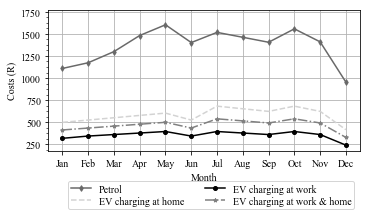

In [34]:
xaxis = home_owner_costs.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, home_owner_costs['h_p'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, home_owner_costs['h_ev'], color='lightgrey', linestyle='--')
ax.plot(xaxis, home_owner_costs['w_ev'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, home_owner_costs['hw_ev'], color='grey', linestyle='-.', marker='*', markersize=ms)
# ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('Costs (R)')
plt.xlabel('Month')
plt.ylim(top=(ax.get_ylim()[1] + 100))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/home_owner/rands.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/home_owner/final/rands(grid).pdf')

#### C02

In [42]:
offline_pv()

pv = stellenbosch.system_output[['p_mp']]/2
pv = pv.shift(365, freq='D')
pv = pv.iloc[:-1,:]
pv.columns=[0]
pv[pv<0] = 0
pv_hour = pv.resample('H').sum()/60000

In [43]:
### c02 provided in kg's ###

startdate = '2019-01-01'
enddate = '2020-01-01'
stellenbosch = world(startdate, enddate, wd)
c02 = pd.DataFrame()
c02['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
c02 = c02.set_index('Date/Time', drop=True)

c02['petrol'] = km.resample('M').sum().values*c02_km*1000
c02['home'] = elect_h.resample('M').sum().values*c02_kWh*1000

elect_hour = elect_w.resample('H').sum()
index_hour = elect_hour.index.isin(elect_hour[elect_hour.iloc[:,0]>0].index)
c02['work'] = (elect_hour.resample('M').sum() - pv_hour[index_hour].resample('M').sum()).values*c02_kWh*1000

elect_hour = elect_hw.resample('H').sum()
index_hour = (elect_hour.index.time < datetime.strptime('2017-01-01 16:00', '%Y-%m-%d %H:%M').time()) & (
    elect_hour.index.isin(elect_hour[(elect_hour.iloc[:,0]>0)].index))
c02['home_work'] = ((elect_hour[index_hour].resample('M').sum() - 
                    pv_hour[index_hour].resample('M').sum()).iloc[:,0].values
                    + (elect_hw[elect_hw.index.time>datetime.strptime(
                        '2017-01-01 16:00', '%Y-%m-%d %H:%M').time()].resample('M').sum()).iloc[:,0].values)
c02['home_work'] *= c02_kWh*1000



In [47]:
xaxis = c02.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, c02['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, c02['home'], color='lightgrey', linestyle='--')
ax.plot(xaxis, c02['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, c02['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
# ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('C02 (kg)')
plt.xlabel('Month')
plt.ylim(bottom=(ax.get_ylim()[0] - 6))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/home_owner/c02.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/home_owner/final/c02(grid).pdf')
c02.columns=['petrol', 'home_only', 'work_only','home_work']
c02.to_csv(path_or_buf = '../output/za_journal/home_owner/data/home_c02.csv')

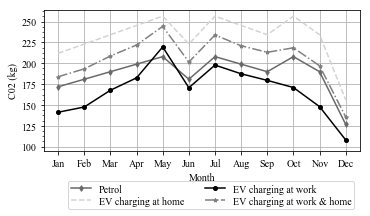

In [96]:
xaxis = c02.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, c02['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, c02['home'], color='lightgrey', linestyle='--')
ax.plot(xaxis, c02['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, c02['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
# ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('C02 (kg)')
plt.xlabel('Month')
plt.ylim(bottom=(ax.get_ylim()[0] - 6))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/home_owner/c02.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/home_owner/final/c02(grid).pdf')

## SU

In [111]:
# %%timeit
r=time.time()
speed = 60
pool_size = 2000
work_arr_full, length_full, duration_full, work_dep_full = mobility_pool(speed, pool_size)
s=time.time()
print(s-r)

0.023935794830322266


In [120]:
l = time.time()
# startdate = '2018-12-15'
# enddate = '2018-12-17'
startdate = '2018-01-01'
enddate = '2019-01-01'


size = 1000
# np_mobile = add_mobility(size, work_arr_full, length_full, duration_full, work_dep_full, True)
stellies_batt = add_battery(size, car['Leaf'], pd.DataFrame())
np_batt = np.hstack((np.arange(size).reshape((size,1)), np.array(stellies_batt)))

stellenbosch = world(startdate, enddate, wd)
# stellenbosch.pv(5, 2, False, True)

stellies_mobile =  pd.DataFrame(data=np_mobile[:,1:3], index=np_mobile[:,0].astype(int), columns=['Duration', 'length'])
for i in range(4):
    a=(np_mobile[:,(3+i)]/60).astype(int)
    b=(np_mobile[:,(3+i)]%60).astype(int)
    x=[]
    for j in range(len(np_mobile[:,(3+i)])):
        x.append(dttime(a[j],b[j]))
    stellies_mobile[i] = x
stellies_mobile.columns=['duration', 'length', 'home_dep', 'work_arr', 'work_dep', 'home_arr']

avoid_peak = True

r=time.time()
batt_profile_hw, elect_hw, np_batt, np_mobile, trip_consumption, np_km = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, True, 
                                                                                    True, True, avoid_peak)
h=time.time()
print(h-r)
np_batt[:,3] = np_batt[0,6]
batt_profile_h, elect_h, np_batt, np_mobile, trip_consumption, np_km_h = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, False, True, 
                                                                                    True, avoid_peak)
j=time.time()
print(j-h)
np_batt[:,3] = np_batt[0,6]
batt_profile_w, elect_w, np_batt, np_mobile, trip_consumption, np_km_w = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, True, False, 
                                                                                    True, avoid_peak)
t=time.time()
print(t-j)


print('Total Time: ',time.time()-l)

offline_pv()

pv = stellenbosch.system_output[['p_mp']]
# pv = pv.shift(365, freq='D')
pv = pv.iloc[:-1,:]
pv.columns=[0]
pv=pv*500

Number of EVs:  1000
Cars plotted in batt_profile:  [121, 103, 415, 428, 160, 84, 36, 29, 417, 213, 490, 323, 413, 102, 415]
2.1533093452453613
Number of EVs:  1000
Cars plotted in batt_profile:  [121, 103, 415, 428, 160, 84, 36, 29, 417, 213, 490, 323, 413, 102, 415]
1.3015530109405518
Number of EVs:  1000
Cars plotted in batt_profile:  [121, 103, 415, 428, 160, 84, 36, 29, 417, 213, 490, 323, 413, 102, 415]
1.3124537467956543
Total Time:  4.779375076293945


In [104]:
car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(days=1), freq='d')
km = pd.DataFrame(np_km)
km['Date/Time'] = car_period
km.set_index('Date/Time', inplace=True)

car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='min')
batt_plot = pd.DataFrame()
batt_plot['Date/Time'] = car_period
batt_plot.set_index('Date/Time', inplace=True)
batt_plot['home'] = batt_profile_h[:-1,0]
batt_plot['home_average'] = batt_profile_h[:-1,:].sum(axis=1)/batt_profile_h.shape[1]
batt_plot['home_work'] = batt_profile_hw[:-1,0]
batt_plot['home_work_average'] = batt_profile_hw[:-1,:].sum(axis=1)/batt_profile_hw.shape[1]
batt_plot['work'] = batt_profile_w[:-1,0]
batt_plot['work_average'] = batt_profile_w[:-1,:].sum(axis=1)/batt_profile_w.shape[1]

elect = pd.DataFrame()
elect['Date/Time'] = car_period
elect.set_index('Date/Time', inplace=True)
elect['home'] = elect_h[:-1, 0]
elect['home_work'] = (elect_hw[:-1, 0])
elect['work'] = elect_w[:-1, 0]
# elect.groupby(elect.index.hour).sum()

# print(np_batt)
# stellies_mobile

In [797]:
elect.to_csv(path_or_buf = '../output/za_journal/su/elect.csv')
batt_plot.to_csv(path_or_buf = '../output/za_journal/su/batt_profile.csv')
stellies_batt.to_csv(path_or_buf = '../output/za_journal/su/stellies_batt.csv')
stellies_mobile.to_csv(path_or_buf = '../output/za_journal/su/stellies_mobile.csv')
km.to_csv(path_or_buf = '../output/za_journal/su/km.csv')

In [48]:
# startdate = '2018-01-01'
# enddate = '2019-01-01'
# # wd=0
# stellenbosch = world(startdate, enddate, wd)


# elect = pd.read_csv('../output/za_journal/su/elect.csv', header=0)
# elect.columns = ['Date/Time', 'home', 'home_work', 'work']
# # elect.system_output=0
# elect.loc[:,'Date/Time'] = pd.to_datetime(elect.loc[:,'Date/Time'])
# elect = elect.set_index('Date/Time')

# offline_pv()

# pv = stellenbosch.system_output[['p_mp']]
# pv = pv.iloc[:-1,:]
# pv.columns=[0]
# pv=pv*500
# # elect.plot()

In [49]:
# su_data
# grid_load = su_data.shift(365, freq='D').resample('T').ffill()
grid_load = su_data.resample('T').ffill()

In [53]:
pk_loads = pd.DataFrame()
pk_loads['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
pk_loads = pk_loads.set_index('Date/Time', drop=True)
pk_loads = pk_loads.shift(12, freq='M')
pk_loads['petrol'] = 0
pk_loads['home'] = 0

pk = (((elect['work'].resample('30min').sum()*2) + su_data[0] - 
             (pv[0].resample('30min').sum()*0.001/30))/su_data['PF'])
pk_time = pk.groupby(pk.index.month).idxmax()

# pk_loads['work'] = (pk[pk_time] - su_data['kVA'][pk_time]).values
pk_loads['work'] = (pk[pk_time]).values
# pk_loads['work'] = (pk[pk_time].values - su_data.kVA.groupby(su_data.index.month).max().values)

pk = (((elect['home_work'].resample('30min').sum()*2) + su_data[0] - 
             (pv[0].resample('30min').sum()*0.001/30))/su_data['PF'])
pk_time = pk.groupby(pk.index.month).idxmax()

# pk_loads['home_work'] = (pk[pk_time] - su_data['kVA'][pk_time]).values
pk_loads['home_work'] = (pk[pk_time]).values
# pk_loads['home_work'] = (pk[pk_time].values - su_data.kVA.groupby(su_data.index.month).max().values)

pk_loads['historic'] = su_data.kVA.groupby(su_data.index.month).max().values

pk_loads*=.001

In [55]:
xaxis = pk_loads.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
line0,=ax.plot(xaxis, pk_loads['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
line1,=ax.plot(xaxis, pk_loads['historic'], color='darkgrey', linestyle='--', marker='^', markersize=ms)
line2,=ax.plot(xaxis, pk_loads['home'], color='lightgrey', linestyle='--')
line3,=ax.plot(xaxis, pk_loads['work'], color='black', linestyle='-', marker='o', markersize=ms)
line4,=ax.plot(xaxis, pk_loads['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('Peak Demand (MVA)')
plt.xlabel('Month')
plt.tight_layout()
plt.subplots_adjust(bottom=.28)


plt.legend(['Petrol','Historic','EV Charging @ Home','EV Charging @ Work','EV Charging @ Work & Home'], labelspacing=0.2,
            bbox_to_anchor=(1.0,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=3, borderpad=0.3, 
            columnspacing=1.3)

# plt.savefig('../output/za_journal/su/peak_demand.pdf')
# plt.grid(b=True)
# plt.savefig('../output/za_journal/su/peak_demand(grid).pdf')
# plt.show()


line5,=ax.plot(np.NaN, np.NaN, '-', color='none', label='')

test = plt.legend([line5,line5,line5, line5], ['                                                            ',
                                               '                                    ','                  ',''], 
                  labelspacing=0.2, bbox_to_anchor=(0.96,-0.01), loc="lower right", 
                  bbox_transform=fig.transFigure, ncol=3, borderpad=0.3, columnspacing=1.3, frameon=True)
ax = plt.gca().add_artist(test)


first_leg = plt.legend([line0,line1,line2],['Petrol','Historic','EV charging at home'], labelspacing=0.2,
            bbox_to_anchor=(0.535,0.04), loc="lower center", bbox_transform=fig.transFigure, ncol=3, borderpad=0.3, 
            columnspacing=1.3, frameon=False)
ax = plt.gca().add_artist(first_leg)
custom_leg = ['']
plt.legend([line3,line4],['EV charging at work','EV charging at work & home'], labelspacing=0.2,
            bbox_to_anchor=(0.535,-0.015), loc="lower center", bbox_transform=fig.transFigure, ncol=5, borderpad=0.3, 
            columnspacing=1.3, frameon=False)

plt.grid(b=False)
# plt.savefig('../output/za_journal/su/peak_demand_custom.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/su/final/peak_demand_custom(grid).pdf')
plt.show()
# pk_loads.columns=['petrol', 'historic', 'home_only', 'work_only','home_work']
pk_loads.to_csv(path_or_buf = '../output/za_journal/su/data/su_pk_loads.csv')

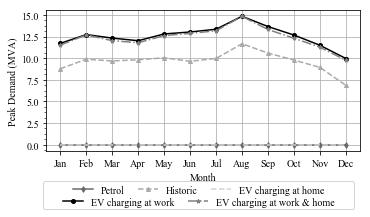

In [43]:
xaxis = pk_loads.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
line0,=ax.plot(xaxis, pk_loads['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
line1,=ax.plot(xaxis, pk_loads['historic'], color='darkgrey', linestyle='--', marker='^', markersize=ms)
line2,=ax.plot(xaxis, pk_loads['home'], color='lightgrey', linestyle='--')
line3,=ax.plot(xaxis, pk_loads['work'], color='black', linestyle='-', marker='o', markersize=ms)
line4,=ax.plot(xaxis, pk_loads['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('Peak Demand (MVA)')
plt.xlabel('Month')
plt.tight_layout()
plt.subplots_adjust(bottom=.28)


plt.legend(['Petrol','Historic','EV Charging @ Home','EV Charging @ Work','EV Charging @ Work & Home'], labelspacing=0.2,
            bbox_to_anchor=(1.0,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=3, borderpad=0.3, 
            columnspacing=1.3)

# plt.savefig('../output/za_journal/su/peak_demand.pdf')
# plt.grid(b=True)
# plt.savefig('../output/za_journal/su/peak_demand(grid).pdf')
# plt.show()


line5,=ax.plot(np.NaN, np.NaN, '-', color='none', label='')

test = plt.legend([line5,line5,line5, line5], ['                                                            ',
                                               '                                    ','                  ',''], 
                  labelspacing=0.2, bbox_to_anchor=(0.96,-0.01), loc="lower right", 
                  bbox_transform=fig.transFigure, ncol=3, borderpad=0.3, columnspacing=1.3, frameon=True)
ax = plt.gca().add_artist(test)


first_leg = plt.legend([line0,line1,line2],['Petrol','Historic','EV charging at home'], labelspacing=0.2,
            bbox_to_anchor=(0.535,0.04), loc="lower center", bbox_transform=fig.transFigure, ncol=3, borderpad=0.3, 
            columnspacing=1.3, frameon=False)
ax = plt.gca().add_artist(first_leg)
custom_leg = ['']
plt.legend([line3,line4],['EV charging at work','EV charging at work & home'], labelspacing=0.2,
            bbox_to_anchor=(0.535,-0.015), loc="lower center", bbox_transform=fig.transFigure, ncol=5, borderpad=0.3, 
            columnspacing=1.3, frameon=False)

plt.grid(b=False)
# plt.savefig('../output/za_journal/su/peak_demand_custom.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/su/final/peak_demand_custom(grid).pdf')
plt.show()

#### Energy Plot (kWh)

In [56]:
### Helpful to determine that no lost kWh ###
elect_hour = elect.resample('H').sum()
index_hour = (elect_hour.index.time < datetime.strptime('2017-01-01 15:00', '%Y-%m-%d %H:%M').time())
print(elect.groupby(elect.index.hour).sum())
elect_hour.loc[index_hour,'home_work'].resample('M').sum().values

                    home      home_work           work
Date/Time                                             
0               0.000000       0.000000       0.000000
1               0.000000       0.000000       0.000000
2               0.000000       0.000000       0.000000
3               0.000000       0.000000       0.000000
4               0.000000       0.000000       0.000000
5               0.000000       0.000000       0.000000
6               0.000000       0.000000       0.000000
7               0.000000   31356.846677   31180.963237
8               0.000000  613894.269740  632737.909211
9               0.000000  590623.414304  842406.176144
10              0.000000  174802.213735  696354.542662
11              0.000000   16302.803162  427327.615966
12              0.000000     112.547375  172762.172743
13              0.000000       0.000000   40502.109891
14              0.000000       0.000000    4743.090801
15            244.395095     246.076951     225.094749
16        

array([107001.26248319, 118890.29164799, 130779.32081279, 124834.80623039,
       136723.83539519, 110101.20577989,  98365.39982168, 136723.83539519,
       118890.29164799, 136723.83539519, 130779.32081279,  77278.6895712 ])

In [57]:
energy = pd.DataFrame()
energy['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
energy = energy.set_index('Date/Time', drop=True)
energy['petrol'] = 0
energy['home'] = 0
energy['work'] = elect.loc[:,'work'].resample('M').sum().values - (pv[0].resample('M').sum()/60000).values
elect_hour = elect.resample('H').sum()
index_hour = ((elect_hour.index.time < datetime.strptime('2017-01-01 15:00', '%Y-%m-%d %H:%M').time()) 
              & (elect_hour.index.time > datetime.strptime('2017-01-01 6:00', '%Y-%m-%d %H:%M').time()))

energy['home_work'] = (elect_hour.loc[index_hour,'home_work'].resample('M').sum().values - 
                       (pv[0].resample('M').sum()/60000).values)

energy=energy.shift(12, freq='M')/1000
# energy.to_csv(path_or_buf = '../output/za_journal/su/energy.csv')

#### C02

In [58]:
### C02 in tons ###
c02 = pd.DataFrame()
c02['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
c02 = c02.set_index('Date/Time', drop=True)
c02 = c02.shift(12, freq='M')
c02['petrol'] = 0
c02['home'] = (energy['home']*1000).values*c02_kWh
c02['work'] = (energy['work']*1000).values*c02_kWh
c02['home_work'] = (energy['home_work']*1000).values*c02_kWh

In [59]:
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)

In [60]:
xaxis = c02.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, c02['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, c02['home'], color='lightgrey', linestyle='--')
ax.plot(xaxis, c02['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, c02['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Delta CO2 (${}$ kg)".format(f._formatSciNotation('%1.10e' % 1000)))
plt.xlabel('Month')

plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/su/c02.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/su/final/c02(grid).pdf')

In [62]:
c02.to_csv(path_or_buf = '../output/za_journal/su/data/su_c02.csv')

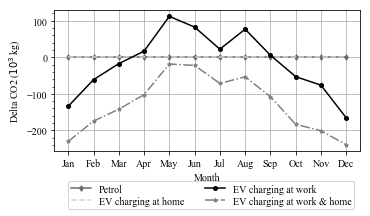

In [50]:
xaxis = c02.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, c02['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, c02['home'], color='lightgrey', linestyle='--')
ax.plot(xaxis, c02['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, c02['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Delta CO2 (${}$ kg)".format(f._formatSciNotation('%1.10e' % 1000)))
plt.xlabel('Month')

plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/su/c02.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/su/final/c02(grid).pdf')

##### Tabled Results

In [136]:
c02=c02*1000

In [137]:
tf=pd.DataFrame(c02.sum())
tf.columns = ['Yearly']

In [139]:
proper_number_table(tf,0)

In [140]:
tf

,Yearly
petrol,R 0.00
home,R 0.00
work,"R -189,426.92"
home_work,"R -1,544,583.46"


#### Costs

In [31]:
def proper_number(num):
    return 'R {:0,.2f}'.format(round(num,2)).replace('R-','-R')
def proper_number_table(num, c):
    j=0
    for i in num.iloc[:,c]:
        num.iloc[j,c] = proper_number(i)
        j+=1

In [63]:
su_2019 = su_data.copy()

In [64]:
elect_half_hour = elect.resample('30min').sum()
elect_half_hour['work'] -= (pv[0].resample('30min').sum()/60000).values
index_half_hour = ((elect_half_hour.index.time > datetime.strptime('2017-01-01 14:00', '%Y-%m-%d %H:%M').time()) 
                   | (elect_half_hour.index.time < datetime.strptime('2017-01-01 7:00', '%Y-%m-%d %H:%M').time()))
# elect_half_hour.groupby(elect_half_hour.index.hour).sum()
elect_half_hour.loc[index_half_hour,'home_work'] = 0
elect_half_hour['home_work'] -= (pv[0].resample('30min').sum()/60000).values
elect_half_hour.loc[:,'home'] = 0

In [65]:
energy_pv, pe_pv, se_pv, ope_pv = energy_profile(elect_half_hour.loc[:,'work'])
kva = pd.DataFrame()
kva['kVA'] = (elect_half_hour.loc[:,'work']*2)/su_2019.loc[:,'PF']
kva = kva.shift(365, freq='D')
work = cost_profile(kva, pe_pv, se_pv, ope_pv, pk_loads['work'], pk_loads['historic'])
profits = energy.copy()
profits['work'] = -work[['Demand', 'pec', 'opec', 'sec']].sum(axis=1).values
profits['work'] += elect['work'].resample('M').sum().values*1.50*.85
energy_pv, pe_pv, se_pv, ope_pv = energy_profile(elect_half_hour.loc[:,'home_work'])
kva = pd.DataFrame()
kva['kVA'] = (elect_half_hour.loc[:,'home_work']*2)/su_2019.loc[:,'PF']
kva = kva.shift(365, freq='D')
home_work = cost_profile(kva, pe_pv, se_pv, ope_pv, pk_loads['home_work'], pk_loads['historic'])
profits['home_work'] = -home_work[['Demand', 'pec', 'opec', 'sec']].sum(axis=1).values
index_hour = ((elect_hour.index.time < datetime.strptime('2017-01-01 15:00', '%Y-%m-%d %H:%M').time()) 
              & (elect_hour.index.time > datetime.strptime('2017-01-01 6:00', '%Y-%m-%d %H:%M').time()))
profits['home_work'] += elect_hour.loc[index_hour,'home_work'].resample('M').sum().values*1.5*.85

In [66]:
tf=pd.DataFrame(profits.sum())
tf.columns = ['Yearly']

In [67]:
proper_number_table(tf,0)

In [146]:
tf

,Yearly
petrol,R 0.00
home,R 0.00
work,"R 1,606,935.97"
home_work,"R 1,441,047.88"


In [144]:
tf.to_latex(index=False)

'\\begin{tabular}{l}\n\\toprule\n         Yearly \\\\\n\\midrule\n         R 0.00 \\\\\n         R 0.00 \\\\\n R 1,606,935.97 \\\\\n R 1,441,047.88 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [69]:
xaxis = profits.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, profits['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, profits['home'], color='lightgrey', linestyle='--')
ax.plot(xaxis, profits['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, profits['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('Revenue (R)')
plt.xlabel('Month')

plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
# plt.grid(b=False)
# plt.savefig('../output/za_journal/su/rands.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/su/final/revenue(grid).pdf')

In [71]:
profits.to_csv(path_or_buf = '../output/za_journal/su/data/su_profits.csv')

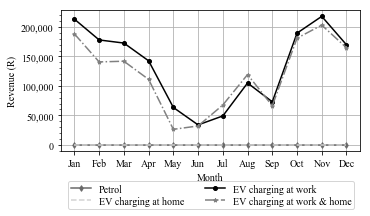

In [58]:
xaxis = profits.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))

ax.plot(xaxis, profits['petrol'], color='dimgrey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, profits['home'], color='lightgrey', linestyle='--')
ax.plot(xaxis, profits['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, profits['home_work'], color='grey', linestyle='-.', marker='*', markersize=ms)
ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('Revenue (R)')
plt.xlabel('Month')

plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
# plt.grid(b=False)
# plt.savefig('../output/za_journal/su/rands.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/su/final/revenue(grid).pdf')

## Grid

In [72]:
su_data=0
su_2019=0
data,data1,data2,data3,wd = 0,0,0,0,0

In [1412]:
# %%timeit
r=time.time()
speed = 60
pool_size = 20000000
work_arr_full, length_full, duration_full, work_dep_full = mobility_pool(speed, pool_size)
s=time.time()
print(s-r)

3.7431535720825195


In [1413]:
l = time.time()
startdate = '2017-01-01'
enddate = '2018-01-01'

size = 1000000

np_mobile = add_mobility(size, work_arr_full, length_full, duration_full, work_dep_full, True)
stellies_batt = add_battery(size, car['Leaf'], pd.DataFrame())
np_batt = np.hstack((np.arange(size).reshape((size,1)), np.array(stellies_batt)))

stellenbosch = world(startdate, enddate, wd)
# stellenbosch.pv(5, 2, False, True)

stellies_mobile =  pd.DataFrame(data=np_mobile[:,1:3], index=np_mobile[:,0].astype(int), columns=['Duration', 'length'])
for i in range(4):
    a=(np_mobile[:,(3+i)]/60).astype(int)
    b=(np_mobile[:,(3+i)]%60).astype(int)
    x=[]
    for j in range(len(np_mobile[:,(3+i)])):
        x.append(dttime(a[j],b[j]))
    stellies_mobile[i] = x
stellies_mobile.columns=['duration', 'length', 'home_dep', 'work_arr', 'work_dep', 'home_arr']

avoid_peak = True

r=time.time()
batt_profile_hw, elect_hw, np_batt, np_mobile, trip_consumption, np_km = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, True, True, 
                                                                                    True, avoid_peak)
h=time.time()
print(h-r)
np_batt[:,3] = np_batt[0,6]
batt_profile_h, elect_h, np_batt, np_mobile, trip_consumption, np_km_h = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, False, True, 
                                                                                    True, avoid_peak)
j=time.time()
print(j-h)
np_batt[:,3] = np_batt[0,6]

batt_profile_w, elect_w, np_batt, np_mobile, trip_consumption, np_km_w = simulation(stellenbosch, 
                                                                                    np_mobile, np_batt, True, False, 
                                                                                    True, avoid_peak)
t=time.time()
print(t-j)


print('Total Time: ',time.time()-l)

offline_pv()

pv = stellenbosch.system_output[['p_mp']]
pv = pv.shift(365, freq='D')
pv = pv.iloc[:-1,:]
pv.columns=[0]
pv=pv*500000

Number of EVs:  1000000
Cars plotted in batt_profile:  [226194, 156636, 353762, 124129, 348709, 186255, 429102, 406469, 227135, 127888, 85921, 383610, 467008, 433704, 170698]


KeyboardInterrupt: 

In [ ]:
car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(days=1), freq='d')
km = pd.DataFrame(np_km)
km['Date/Time'] = car_period
km.set_index('Date/Time', inplace=True)

car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='min')
batt_plot = pd.DataFrame()
batt_plot['Date/Time'] = car_period
batt_plot.set_index('Date/Time', inplace=True)
batt_plot['home'] = batt_profile_h[:-1,0]
batt_plot['home_average'] = batt_profile_h[:-1,:].sum(axis=1)/batt_profile_h.shape[1]
batt_plot['home_work'] = batt_profile_hw[:-1,0]
batt_plot['home_work_average'] = batt_profile_hw[:-1,:].sum(axis=1)/batt_profile_hw.shape[1]
batt_plot['work'] = batt_profile_w[:-1,0]
batt_plot['work_average'] = batt_profile_w[:-1,:].sum(axis=1)/batt_profile_w.shape[1]

elect = pd.DataFrame()
elect['Date/Time'] = car_period
elect.set_index('Date/Time', inplace=True)
elect['home'] = elect_h[:-1, 0]
elect['home_work'] = (elect_hw[:-1, 0])
elect['work'] = elect_w[:-1, 0]

In [ ]:
elect.to_csv(path_or_buf = '../output/za_journal/grid/elect.csv')
batt_plot.to_csv(path_or_buf = '../output/za_journal/grid/batt_profile.csv')
stellies_batt.to_csv(path_or_buf = '../output/za_journal/grid/stellies_batt.csv')
stellies_mobile.to_csv(path_or_buf = '../output/za_journal/grid/stellies_mobile.csv')
km.to_csv(path_or_buf = '../output/za_journal/grid/km.csv')

In [73]:
startdate = '2017-01-01'
enddate = '2018-01-01'
wd=0
stellenbosch = world(startdate, enddate, wd)


km = pd.read_csv('../output/za_journal/home_owner/km.csv', header=0)
km.loc[:,'Date/Time'] = pd.to_datetime(km.loc[:,'Date/Time'])
km = km.set_index('Date/Time')

elect = pd.read_csv('../output/za_journal/home_owner/elect.csv', header=0)
elect.columns = ['Date/Time', 'home', 'home_work', 'work']
# elect.system_output=0
elect.loc[:,'Date/Time'] = pd.to_datetime(elect.loc[:,'Date/Time'])
elect = elect.set_index('Date/Time')
elect_hw = pd.DataFrame(elect['home_work'])
elect_hw.columns=[0]
elect_w = pd.DataFrame(elect['work'])
elect_w.columns=[0]
elect_h = pd.DataFrame(elect['home'])
elect_h.columns=[0]

km = pd.read_csv('../output/za_journal/grid/km.csv', header=0)
km.loc[:,'Date/Time'] = pd.to_datetime(km.loc[:,'Date/Time'])
km = km.set_index('Date/Time')

elect = pd.read_csv('../output/za_journal/grid/elect.csv', header=0)
elect.columns = ['Date/Time', 'home', 'home_work', 'work']
# elect.system_output=0
elect.loc[:,'Date/Time'] = pd.to_datetime(elect.loc[:,'Date/Time'])
elect = elect.set_index('Date/Time')

offline_pv()
pv = stellenbosch.system_output[['p_mp']]
pv = pv.shift(365, freq='D')
pv = pv.iloc[:-1,:]
pv.columns=[0]
pv=pv*500000
# elect.plot()

#### Energy Plot (GWh)

In [74]:
energy = pd.DataFrame()
energy['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
energy = energy.set_index('Date/Time', drop=True)
elect_hour = elect.resample('H').sum()

energy['petrol'] = 0
energy['home'] = elect.loc[:,'home'].resample('M').sum().values
energy['work'] = elect.loc[:,'work'].resample('M').sum().values - (pv[0].resample('M').sum()/60000).values
energy['home_work'] = (elect.loc[:,'home_work'].resample('M').sum().values - (pv[0].resample('M').sum()/60000).values)
energy = energy*0.001*0.001
energy=energy.shift(24, freq='M')
# energy.to_csv(path_or_buf = '../output/za_journal/grid/energy.csv')

#### C02

In [75]:
### C02 in tons ###
c02 = pd.DataFrame()
c02['Date/Time'] = pd.period_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=1), freq='M')
c02 = c02.set_index('Date/Time', drop=True)
c02 = c02.shift(24, freq='M')
c02['petrol'] = km.resample('M').sum().values*c02_km/1000
c02['home'] = energy['home'].values*c02_MWh
c02['work'] = energy['work'].values*c02_MWh
c02['home_work'] = energy['home_work'].values*c02_MWh
# c02=c02*1000*1000

In [76]:
c02['petrol'] = 0

In [77]:
xaxis = c02.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
ax.plot(xaxis, c02['petrol'], color='grey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, c02['home'], color='dimgrey', linestyle='--')
ax.plot(xaxis, c02['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, c02['home_work'], color='lightgrey', linestyle='-.', marker='*', markersize=ms)
ax.set_ylabel("C02 (${}$ kg)".format(f._formatSciNotation('%1.10e' % 1000000)))
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Month')
# plt.ylim(bottom=(ax.get_ylim()[0] - 6))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.97,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/c02.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/grid/final/c02(grid)_no_petrol_delta.pdf')

In [78]:
c02.to_csv(path_or_buf = '../output/za_journal/grid/data/grid_c02.csv')

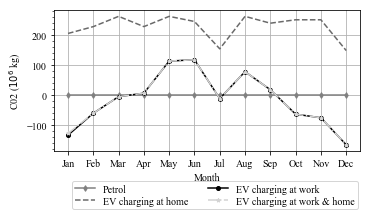

In [63]:
xaxis = c02.index.strftime('%b')
ms=4
fig, ax = plt.subplots(figsize=(5.25,3))
# fig, ax = plt.subplots(figsize=(8.5,3.8))
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
ax.plot(xaxis, c02['petrol'], color='grey', linestyle='-', marker='d', markersize=ms)
ax.plot(xaxis, c02['home'], color='dimgrey', linestyle='--')
ax.plot(xaxis, c02['work'], color='black', linestyle='-', marker='o', markersize=ms)
ax.plot(xaxis, c02['home_work'], color='lightgrey', linestyle='-.', marker='*', markersize=ms)
ax.set_ylabel("C02 (${}$ kg)".format(f._formatSciNotation('%1.10e' % 1000000)))
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Month')
# plt.ylim(bottom=(ax.get_ylim()[0] - 6))
plt.tight_layout()


plt.subplots_adjust(bottom=.28)
plt.legend(['Petrol', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.97,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)
plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/c02.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/grid/final/c02(grid)_no_petrol_delta.pdf')

,petrol,home,work,home_work
Date/Time,,,,
2020-01,1.657230e+08,2.044243e+08,-1.333831e+08,-1.277046e+08
2020-02,1.841366e+08,2.271385e+08,-6.066566e+07,-6.066566e+07
2020-03,2.117571e+08,2.612093e+08,-5.493617e+06,-5.493619e+06
2020-04,1.841366e+08,2.271388e+08,5.999423e+06,5.999419e+06
2020-05,2.117571e+08,2.612090e+08,1.126230e+08,1.126230e+08
2020-06,1.979470e+08,2.441742e+08,1.170667e+08,1.170673e+08
2020-07,1.242946e+08,1.533213e+08,-1.191876e+07,-1.191857e+07
2020-08,2.117571e+08,2.612093e+08,7.750139e+07,7.750137e+07
2020-09,1.933434e+08,2.384957e+08,1.757664e+07,1.757594e+07


In [18]:
tf=pd.DataFrame((c02*1000*1000).sum())
tf.columns = ['Yearly']

In [21]:
proper_number_table(tf,0)

In [22]:
tf

,Yearly
petrol,R 0.00
home,"R 2,725,665,006.87"
work,"R -185,421,958.88"
home_work,"R -179,743,487.15"


#### Daily Profile

In [79]:
grid = eskom.resample('30min').ffill()

In [80]:
elect_demand = elect.resample('30min').sum()*2*0.001
pv_kW = (pv.shift(-(365*2), freq='D'))*0.001*0.001
pv_kW = pv_kW.resample('30min').sum()/30
car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=60), freq='30min')

demand = pd.DataFrame()
demand['Date/Time'] = car_period
demand = demand.set_index('Date/Time', drop=True)
demand['eskom'] = grid[0]
demand['home'] = (elect_demand.loc[:,'home'] + grid[0])
demand['work'] = (elect_demand.loc[:,'work'] - pv_kW[0]+grid[0])
demand['home_work'] = (elect_demand.loc[:,'home_work'] - pv_kW[0]+grid[0])
# demand = demand.shift(30, freq='min')
demand = demand*0.001
demand_jan_plot = demand['2017-01-10':'2017-01-11 02:00'].shift((365*2), freq='D')
demand_june_plot = demand['2017-06-05':'2017-06-06 02:00'].shift((365*2), freq='D')

In [82]:
xaxis = demand_jan_plot.index
x_labels = demand_jan_plot.index.time
ms=4
me = 2
fig, ax = plt.subplots(figsize=(5.25,3))

ax.plot(xaxis, demand_jan_plot['eskom'], color='black', linestyle='-', marker='d', markersize=0, markevery=me)
ax.plot(xaxis, demand_jan_plot['home'], color='grey', linestyle=':', marker='o', markersize=ms, markevery=me)
ax.plot(xaxis, demand_jan_plot['work'], color='dimgrey', linestyle='--', marker='o', markersize=0, markevery=me)
ax.plot(xaxis, demand_jan_plot['home_work'], color='black', linestyle='-.', marker='*', markersize=ms, markevery=me)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_ylabel('Grid Demand (GW)')
# plt.xlabel('Month')
plt.tight_layout()

h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()

plt.subplots_adjust(bottom=.28)
plt.legend(['Grid', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.528,-0.01), loc="lower center", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)

# plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/jan_profile.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/grid/final/jan_profile(grid).pdf')

In [83]:
demand_jan_plot.to_csv(path_or_buf = '../output/za_journal/grid/data/grid_january_demand.csv')

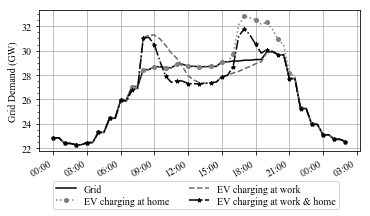

In [67]:
xaxis = demand_jan_plot.index
x_labels = demand_jan_plot.index.time
ms=4
me = 2
fig, ax = plt.subplots(figsize=(5.25,3))

ax.plot(xaxis, demand_jan_plot['eskom'], color='black', linestyle='-', marker='d', markersize=0, markevery=me)
ax.plot(xaxis, demand_jan_plot['home'], color='grey', linestyle=':', marker='o', markersize=ms, markevery=me)
ax.plot(xaxis, demand_jan_plot['work'], color='dimgrey', linestyle='--', marker='o', markersize=0, markevery=me)
ax.plot(xaxis, demand_jan_plot['home_work'], color='black', linestyle='-.', marker='*', markersize=ms, markevery=me)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_ylabel('Grid Demand (GW)')
# plt.xlabel('Month')
plt.tight_layout()

h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()

plt.subplots_adjust(bottom=.28)
plt.legend(['Grid', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.528,-0.01), loc="lower center", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)

# plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/jan_profile.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/grid/final/jan_profile(grid).pdf')

In [84]:
xaxis = demand_june_plot.index
x_labels = demand_june_plot.index.time
ms=4
me = 2
fig, ax = plt.subplots(figsize=(5.25,3))

ax.plot(xaxis, demand_june_plot['eskom'], color='black', linestyle='-', marker='d', markersize=0, markevery=me)
ax.plot(xaxis, demand_june_plot['home'], color='grey', linestyle=':', marker='o', markersize=ms, markevery=me)
ax.plot(xaxis, demand_june_plot['work'], color='dimgrey', linestyle='--', marker='o', markersize=0, markevery=me)
ax.plot(xaxis, demand_june_plot['home_work'], color='black', linestyle='-.', marker='*', markersize=ms, markevery=me)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_ylabel('Grid Demand (GW)')
# plt.xlabel('Month')
plt.tight_layout()

h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()

plt.subplots_adjust(bottom=.28)
plt.legend(['Grid', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.528,-0.01), loc="lower center", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)

# plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/june_profile.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/grid/final/june_profile(grid).pdf')

In [85]:
demand_june_plot.to_csv(path_or_buf = '../output/za_journal/grid/data/grid_june_demand.csv')

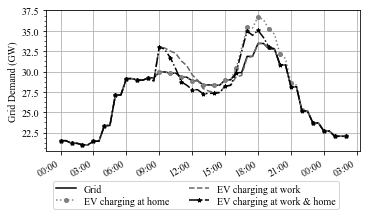

In [68]:
xaxis = demand_june_plot.index
x_labels = demand_june_plot.index.time
ms=4
me = 2
fig, ax = plt.subplots(figsize=(5.25,3))

ax.plot(xaxis, demand_june_plot['eskom'], color='black', linestyle='-', marker='d', markersize=0, markevery=me)
ax.plot(xaxis, demand_june_plot['home'], color='grey', linestyle=':', marker='o', markersize=ms, markevery=me)
ax.plot(xaxis, demand_june_plot['work'], color='dimgrey', linestyle='--', marker='o', markersize=0, markevery=me)
ax.plot(xaxis, demand_june_plot['home_work'], color='black', linestyle='-.', marker='*', markersize=ms, markevery=me)

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xticklabels(x_labels)
plt.xticks(rotation=90)
ax.set_ylabel('Grid Demand (GW)')
# plt.xlabel('Month')
plt.tight_layout()

h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()

plt.subplots_adjust(bottom=.28)
plt.legend(['Grid', 'EV charging at home', 'EV charging at work', 'EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.528,-0.01), loc="lower center", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3)

# plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/june_profile.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/grid/final/june_profile(grid).pdf')

#### Break eskom with peak

In [303]:
# %%timeit
r=time.time()
speed = 60
pool_size = 16000000
work_arr_full, length_full, duration_full, work_dep_full = mobility_pool(speed, pool_size)
s=time.time()
print(s-r)

2.9476494789123535


In [660]:
size = 2000
begin = 100
step = 100

size = 8000000
begin = 1000000
step = 10000

np_mobile = add_mobility(size, work_arr_full, length_full, duration_full, work_dep_full, True)
stellies_batt = add_battery(size, car['Leaf'], pd.DataFrame())
np_batt = np.hstack((np.arange(size).reshape((size,1)), np.array(stellies_batt)))
total=time.time()
for i in range(1,13):
    l = time.time()
    if (i+1)==10:
        startdate = '2017-0{}-01'.format(i)
        enddate = '2017-{}-01'.format(i+1)
    elif i == 12:
        startdate = '2017-{}-01'.format(i)
        enddate = '2018-01-01'
    elif i>=10:
        startdate = '2017-{}-01'.format(i)
        enddate = '2017-{}-01'.format(i+1)

    else:
        startdate = '2017-0{}-01'.format(i)
        enddate = '2017-0{}-01'.format(i+1)

    stellenbosch = world(startdate, enddate, wd)
    avoid_peak = False  
    print('Number of iterations: {}'.format((size-begin)/step))
    
    r=time.time()
    batt_profile_hw, elect_hw, np_batt, np_mobile, trip_consumption, np_km = break_eskom_sim(stellenbosch, 
                                                                                            np_mobile, np_batt, True, True,
                                                                                            True, avoid_peak, begin, step, 
                                                                                            size)
    h=time.time()
    print(h-r)
    np_batt[:,3] = np_batt[0,6]
    batt_profile_h, elect_h, np_batt, np_mobile, trip_consumption, np_km_h = break_eskom_sim(stellenbosch, 
                                                                                        np_mobile, np_batt, False, True, 
                                                                                        True, avoid_peak, begin, step,
                                                                                        size)
    j=time.time()
    print(j-h)
    np_batt[:,3] = np_batt[0,6]
    batt_profile_w, elect_w, np_batt, np_mobile, trip_consumption, np_km_w = break_eskom_sim(stellenbosch, 
                                                                                        np_mobile, np_batt, True, False, 
                                                                                        True, avoid_peak, begin, step, 
                                                                                        size)
    t=time.time()
    print(t-j)
    month = stellenbosch.start.strftime('%b')
    elect_hw.to_csv(path_or_buf = ('../output/za_journal/grid/break_eskom/'+month+'/'+month+'_hw.csv'))
    elect_h.to_csv(path_or_buf = ('../output/za_journal/grid/break_eskom/'+month+'/'+month+'_h.csv'))
    elect_w.to_csv(path_or_buf = ('../output/za_journal/grid/break_eskom/'+month+'/'+month+'_w.csv'))
    
    print('{} total time: {}'.format((stellenbosch.start.strftime('%b')) ,(time.time()-l)))
print('Simulation Time: {}'.format(time.time()-total))

Number of iterations: 700.0
1062.5787899494171
554.9497249126434
542.6504666805267
Jan total time: 2235.2438490390778
Number of iterations: 700.0
1157.8809962272644
609.0059044361115
597.6158785820007
Feb total time: 2435.6132929325104
Number of iterations: 700.0
1321.0584592819214
705.3461222648621
693.5381252765656
Mar total time: 2798.964329481125
Number of iterations: 700.0
1159.9609932899475
619.1208119392395
608.6829993724823
Apr total time: 2461.89998960495
Number of iterations: 700.0
1332.4870221614838
706.7708988189697
691.8797452449799
May total time: 2809.9081375598907
Number of iterations: 700.0
1243.7054615020752
655.2989642620087
650.6118092536926
Jun total time: 2629.13494682312
Number of iterations: 700.0
783.8346581459045
416.6380844116211
409.5348701477051
Jul total time: 1686.5336928367615
Number of iterations: 700.0
1324.9650058746338
709.4837441444397
694.1934633255005
Aug total time: 2807.5451838970184
Number of iterations: 700.0
1211.864957332611
645.286141395568

#### Max Demand

In [87]:
from matplotlib.ticker import AutoMinorLocator

In [88]:
def break_max_demand(stellenbosch, elect_h, elect_hw, elect_w, grid, pv, eskom_capacity, max_demand):
    car_period = pd.date_range(stellenbosch.start, stellenbosch.end-timedelta(minutes=30), freq='30min')
    pv_MW = pd.DataFrame()
    pv_MW['Date/Time'] = car_period
    pv_MW = pv_MW.set_index('Date/Time', drop=True)

    demand_hw = (elect_hw.resample('30min').sum()*2*0.001)
    demand_h = (elect_h.resample('30min').sum()*2*0.001)
    demand_w = (elect_w.resample('30min').sum()*2*0.001)
    for i in elect_h.columns:
        demand_hw.loc[:,i] += grid.loc[car_period,0]
        demand_h.loc[:,i] += grid.loc[car_period,0]
        demand_w.loc[:,i] += grid.loc[car_period,0]
        pv_MW[i] = (pv.loc[car_period, 'p_mp']*0.001*0.001*i)
    demand_hw -= pv_MW
    demand_w -= pv_MW
    month = stellenbosch.start.strftime('%b')
    broken = (demand_w >= eskom_capacity).any(axis=0)
    broken = (demand_w.iloc[:,broken.values]).iloc[:,0:1].columns[0]
    max_demand.loc[month, 'Work'] = broken
    broken = (demand_hw >= eskom_capacity).any(axis=0)
    broken = (demand_hw.iloc[:,broken.values]).iloc[:,0:1].columns[0]
    max_demand.loc[month, 'Home/Work'] = broken
    broken = (demand_h >= eskom_capacity).any(axis=0)
    broken = (demand_h.iloc[:,broken.values]).iloc[:,0:1].columns[0]
    max_demand.loc[month, 'Home'] = broken

In [89]:
grid = eskom.resample('30min').ffill()

offline_pv()
pv = stellenbosch.system_output[['p_mp']]
pv = pv.shift(-365, freq='D')
pv = pv.iloc[:-1,:].resample('30min').sum()/60
max_demand = pd.DataFrame()
max_demand['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
max_demand = max_demand.set_index('Month', drop=True)
max_demand['Home'] = 0
max_demand['Home/Work'] = 0
max_demand['Work'] = 0

In [90]:
# elect = pd.read_csv('../output/za_journal/grid/elect.csv', header=0)
for i in range(1,13):
    if (i+1)==10:
        startdate = '2017-0{}-01'.format(i)
        enddate = '2017-{}-01'.format(i+1)
    elif i == 12:
        startdate = '2017-{}-01'.format(i)
        enddate = '2018-01-01'
    elif i>=10:
        startdate = '2017-{}-01'.format(i)
        enddate = '2017-{}-01'.format(i+1)

    else:
        startdate = '2017-0{}-01'.format(i)
        enddate = '2017-0{}-01'.format(i+1)

    stellenbosch = world(startdate, enddate, wd)
    month = stellenbosch.start.strftime('%b')
    elect_hw = pd.read_csv(('../output/za_journal/grid/break_eskom/'+month+'/'+month+'_hw.csv'), header=0)
    elect_h = pd.read_csv(('../output/za_journal/grid/break_eskom/'+month+'/'+month+'_h.csv'), header=0)
    elect_w = pd.read_csv(('../output/za_journal/grid/break_eskom/'+month+'/'+month+'_w.csv'), header=0)
    elect_hw.loc[:,'Date/Time'] = pd.to_datetime(elect_hw.loc[:,'Date/Time'])
    elect_hw = elect_hw.set_index('Date/Time')
    elect_h.loc[:,'Date/Time'] = pd.to_datetime(elect_h.loc[:,'Date/Time'])
    elect_h = elect_h.set_index('Date/Time')
    elect_w.loc[:,'Date/Time'] = pd.to_datetime(elect_w.loc[:,'Date/Time'])
    elect_w = elect_w.set_index('Date/Time')
    elect_hw.columns, elect_h.columns, elect_w.columns = (elect_hw.columns.astype(int), elect_h.columns.astype(int), 
                                                          elect_w.columns.astype(int))
    break_max_demand(stellenbosch, elect_h, elect_hw, elect_w, grid, pv, eskom_capacity, max_demand)
    
max_demand.to_csv(path_or_buf = '../output/za_journal/grid/max_demand.csv')

KeyboardInterrupt: 

In [309]:
# max_demand.to_csv(path_or_buf = '../output/za_journal/grid/max_demand.csv')

In [93]:
max_demand =pd.read_csv('../output/za_journal/grid/max_demand.csv')

In [95]:
max_demand = max_demand.set_index('Month')

In [98]:
max_demand = max_demand/1000000
# max_demand = max_demand.drop(['index'], axis=1)

In [100]:
colorz=['grey', 'dimgrey', 'black']
markerz=['s','^','h']
ms = 4
fig, ax = plt.subplots(figsize=(5.25,3))
ax.plot(max_demand.index, max_demand.Home, linestyle='--', 
#         marker=markerz[0], markerfacecolor='none', markersize=ms, 
        color=colorz[0])
ax.plot(max_demand.index, max_demand['Work'], linestyle='-', 
#         marker=markerz[2], markerfacecolor='none', markersize=ms, 
#         markerfacecolor='none',
        marker='o', markersize=ms, 
        color=colorz[2])
ax.plot(max_demand.index, max_demand['Home/Work'], linestyle='-.', 
#         marker=markerz[1], markerfacecolor='none',markersize=ms,
#         markerfacecolor='none',
        marker='*', markersize=ms, 
        color=colorz[1])

# step=500000.0
# plt.yticks(np.arange(max_demand.min().values[1:].min(), round(max_demand.max().values[1:].max()/100000)*100000 + 60000, step))
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.ylabel('Number of EVs (Millions)')
plt.xlabel('Month')
plt.ylim(bottom=4, top=7)

plt.tight_layout()
plt.subplots_adjust(bottom=.28)
plt.legend(['EV charging at home','EV charging at work','EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3,
          framealpha=1)
plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/break_eskom.pdf')
plt.grid(b=True)
# plt.savefig('../output/za_journal/grid/final/break_eskom(grid).pdf')

In [101]:
max_demand.to_csv(path_or_buf = '../output/za_journal/grid/data/grid_max_demand.csv')

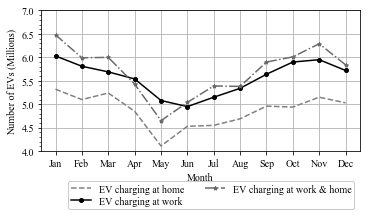

In [85]:
colorz=['grey', 'dimgrey', 'black']
markerz=['s','^','h']
ms = 4
fig, ax = plt.subplots(figsize=(5.25,3))
ax.plot(max_demand.index, max_demand.Home, linestyle='--', 
#         marker=markerz[0], markerfacecolor='none', markersize=ms, 
        color=colorz[0])
ax.plot(max_demand.index, max_demand['Work'], linestyle='-', 
#         marker=markerz[2], markerfacecolor='none', markersize=ms, 
#         markerfacecolor='none',
        marker='o', markersize=ms, 
        color=colorz[2])
ax.plot(max_demand.index, max_demand['Home/Work'], linestyle='-.', 
#         marker=markerz[1], markerfacecolor='none',markersize=ms,
#         markerfacecolor='none',
        marker='*', markersize=ms, 
        color=colorz[1])

# step=500000.0
# plt.yticks(np.arange(max_demand.min().values[1:].min(), round(max_demand.max().values[1:].max()/100000)*100000 + 60000, step))
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.ylabel('Number of EVs (Millions)')
plt.xlabel('Month')
plt.ylim(bottom=4, top=7)

plt.tight_layout()
plt.subplots_adjust(bottom=.28)
plt.legend(['EV charging at home','EV charging at work','EV charging at work & home'], labelspacing=0.2
            ,bbox_to_anchor=(.96,-0.01), loc="lower right", bbox_transform=fig.transFigure, ncol=2, borderpad=0.3,
          framealpha=1)
plt.grid(b=False)
# plt.savefig('../output/za_journal/grid/break_eskom.pdf')
plt.grid(b=True)
plt.savefig('../output/za_journal/grid/final/break_eskom(grid).pdf')